# Single qubit gates
## Isolated transitions

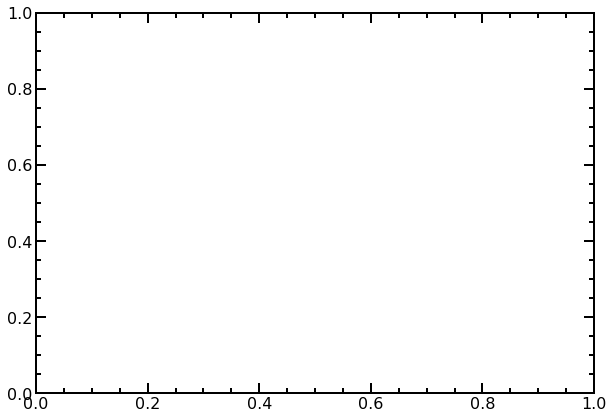

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_evolgates_double as gates_double
from Fluxonium_hamiltonians import qchard_rotope as op
from scipy.optimize import minimize
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [2]:
savefig = False
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [3]:
#Device parameters
nlev_lc = 20
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 1  # inductive energy
    E_C = 1.0  # charging energy
    E_J = 7  # Josephson energy
    phi_ext = 0.96*np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J = E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)
H_nodrive = qubit.H()

state_0 = basis(nlev_single,0)
state_1 = basis(nlev_single,1)
state_2 = basis(nlev_single,2)
state_3 = basis(nlev_single,3)
state_4 = basis(nlev_single,4)

state_sup02 = (state_0 + state_2).unit()
state_sup13 = (state_1 + state_3).unit()
state_sup23 = (state_2 + state_3).unit()

P0 = state_0 * state_0.dag()
P1 = state_1 * state_1.dag()
P2 = state_2 * state_2.dag()
P3 = state_3 * state_3.dag()
P4 = state_4 * state_4.dag()

## Using propagator to optimize individual gates

### 0-2 transition

5.642505395868843e-06
0.33333392957315056


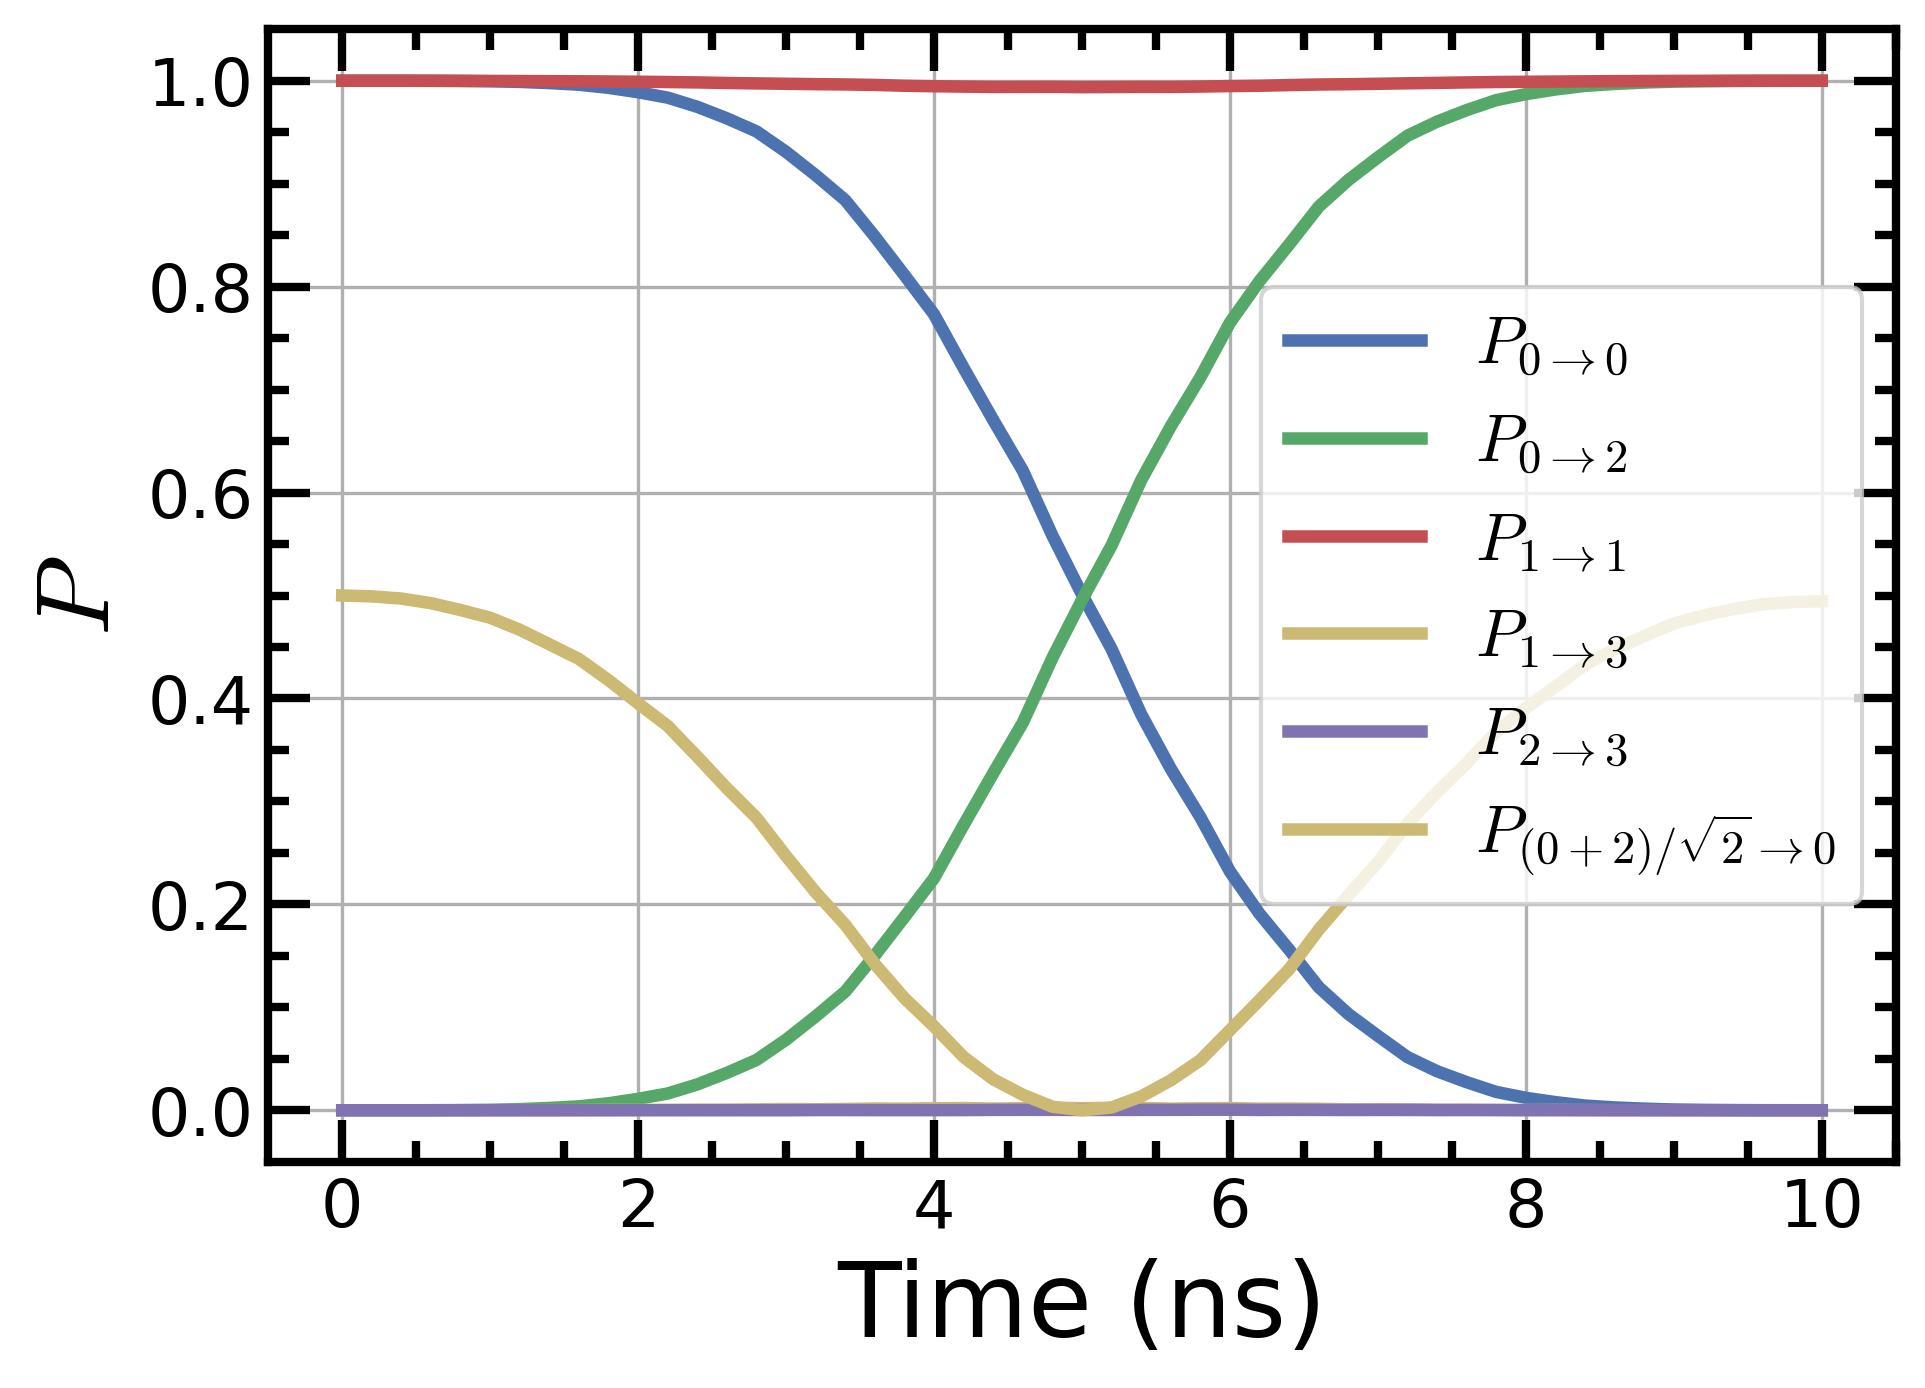

In [100]:
#Gate parameter
T_gate_02 = 10 #ns
t_points_02 = np.linspace(0, T_gate_02, 5 * int(T_gate_02) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

ini_state = 0
fin_state = 2
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_02, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

trans_prob_00 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
trans_prob_23 = gates.prob_transition(U_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U_t, state_sup23, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points_02, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_02, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_02, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_02, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_02, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_02, trans_prob_sup02to0, label=r'$P_{(0+2)/\sqrt{2}\rightarrow 0}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

print (1-trans_prob_02[-1]-trans_prob_00[-1])

U_proj = np.zeros((2,2))
U_ideal = op.sigy(N=nlev_single)
U_real = U_nothing[-1]*U_t[-1]

U_real = Qobj(P0*U_real + P2*U_real)

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel)

In [106]:
U_ideal = sigmay()
def infidelity_02(drag_coeff):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_02, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d=omega_d)
    U_f = U_nothing_1[-1]*U_t[-1]
    U_real = np.diag(np.zeros(2, dtype = complex))
    U_real[0,0] = U_f[0,0]
    U_real[0,1] = U_f[0,2]
    U_real[1,0] = U_f[2,0]
    U_real[1,1] = U_f[2,2]
    U_real = Qobj(U_real)

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)
print (infidelity_02(0))

0.6666679473172223


0.6666668304705476
-0.21763124336505027


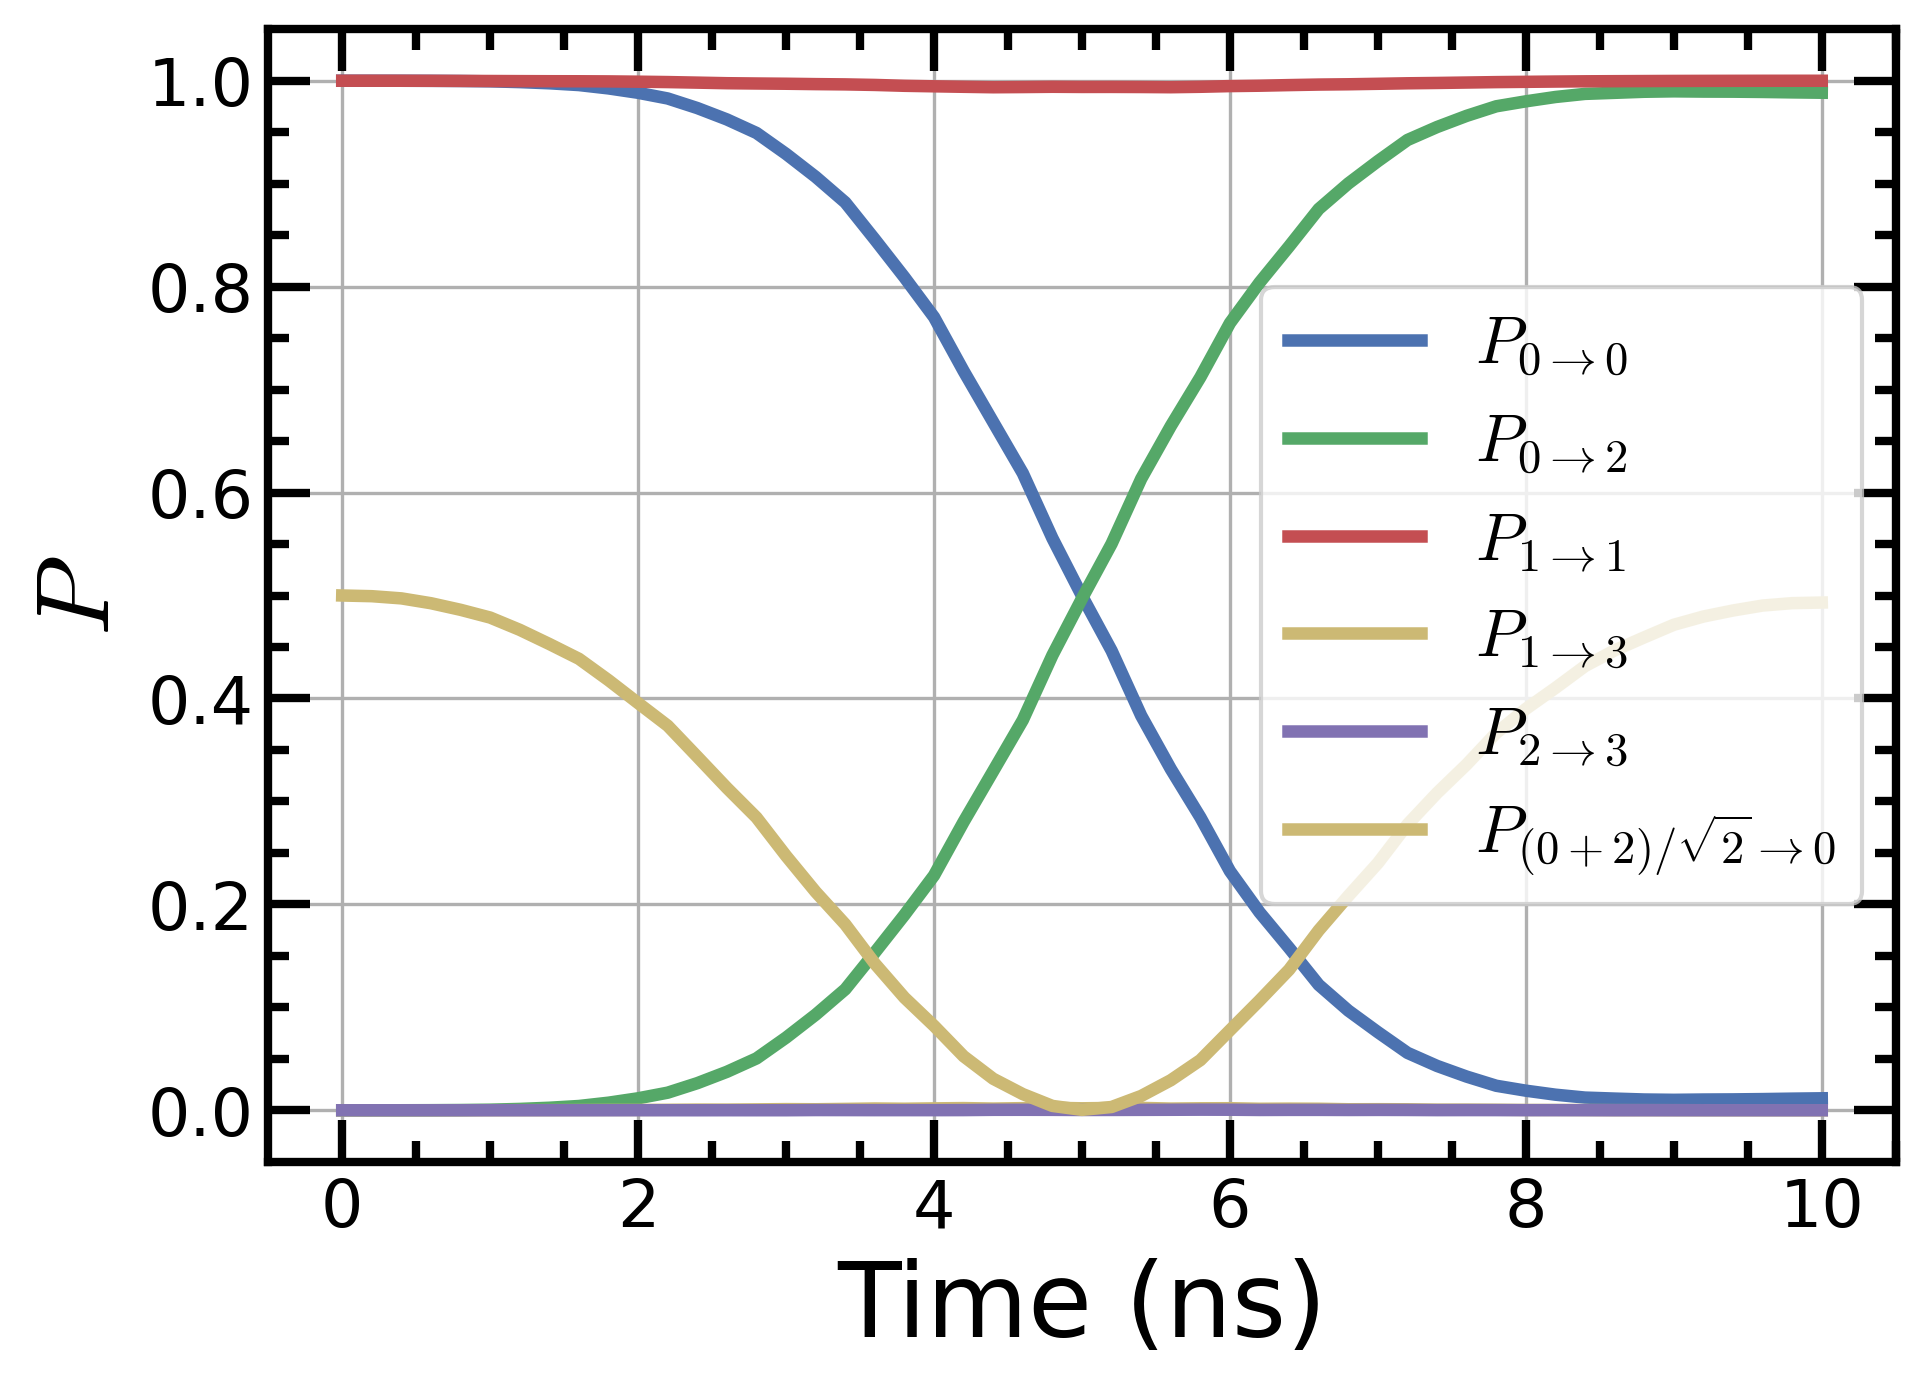

In [107]:
opt = minimize(infidelity_02, x0 = [0.0], method = 'Powell', tol = 1e-8)
print (opt.fun)
print (opt.x[0])

## Check
drag_coeff_02 = opt.x[0]
ini_state = 0
fin_state = 2
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U02_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_02, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing_1 = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_02, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d=omega_d)

trans_prob_00 = gates.prob_transition(U02_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U02_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U02_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U02_t, state_1, state_3)
trans_prob_23 = gates.prob_transition(U02_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U02_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U02_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U02_t, state_sup23, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points_02, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_02, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_02, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_02, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_02, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_02, trans_prob_sup02to0, label=r'$P_{(0+2)/\sqrt{2}\rightarrow 0}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

In [108]:
print(U_nothing_1[-1]*U02_t[-1])

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[ 2.87953943e-03+1.07849620e-01j -3.65258162e-03+4.06007696e-04j
  -9.93469823e-01-3.68597832e-02j -7.53807933e-04+5.53342763e-05j
   2.30328683e-03+6.35969780e-04j]
 [ 2.85503728e-03+2.26019342e-03j  9.99982906e-01-2.94981151e-03j
  -3.39377430e-03-8.26992400e-04j  1.45489452e-05+9.86505233e-05j
  -1.04080087e-04+7.20696959e-05j]
 [ 9.93468920e-01+3.68823110e-02j -2.96653370e-03+1.77591128e-03j
   1.08653073e-02-1.07338673e-01j -6.85724594e-04+1.20965461e-04j
   9.92769664e-04+2.36766055e-03j]
 [ 6.97419684e-04+1.15140457e-04j -4.03117754e-06+1.01547275e-04j
  -7.44819256e-04-3.59046498e-05j  9.88057167e-01-1.54062735e-01j
  -1.64835731e-03+1.98572156e-03j]
 [-1.31764446e-03+1.96761407e-03j  1.05392223e-04+6.89650631e-05j
   2.57392131e-03-1.99096519e-04j  1.78195559e-03+1.86207467e-03j
   9.96452788e-01+8.40408487e-02j]]


### 1-3 transition

3.8167222986940086e-05


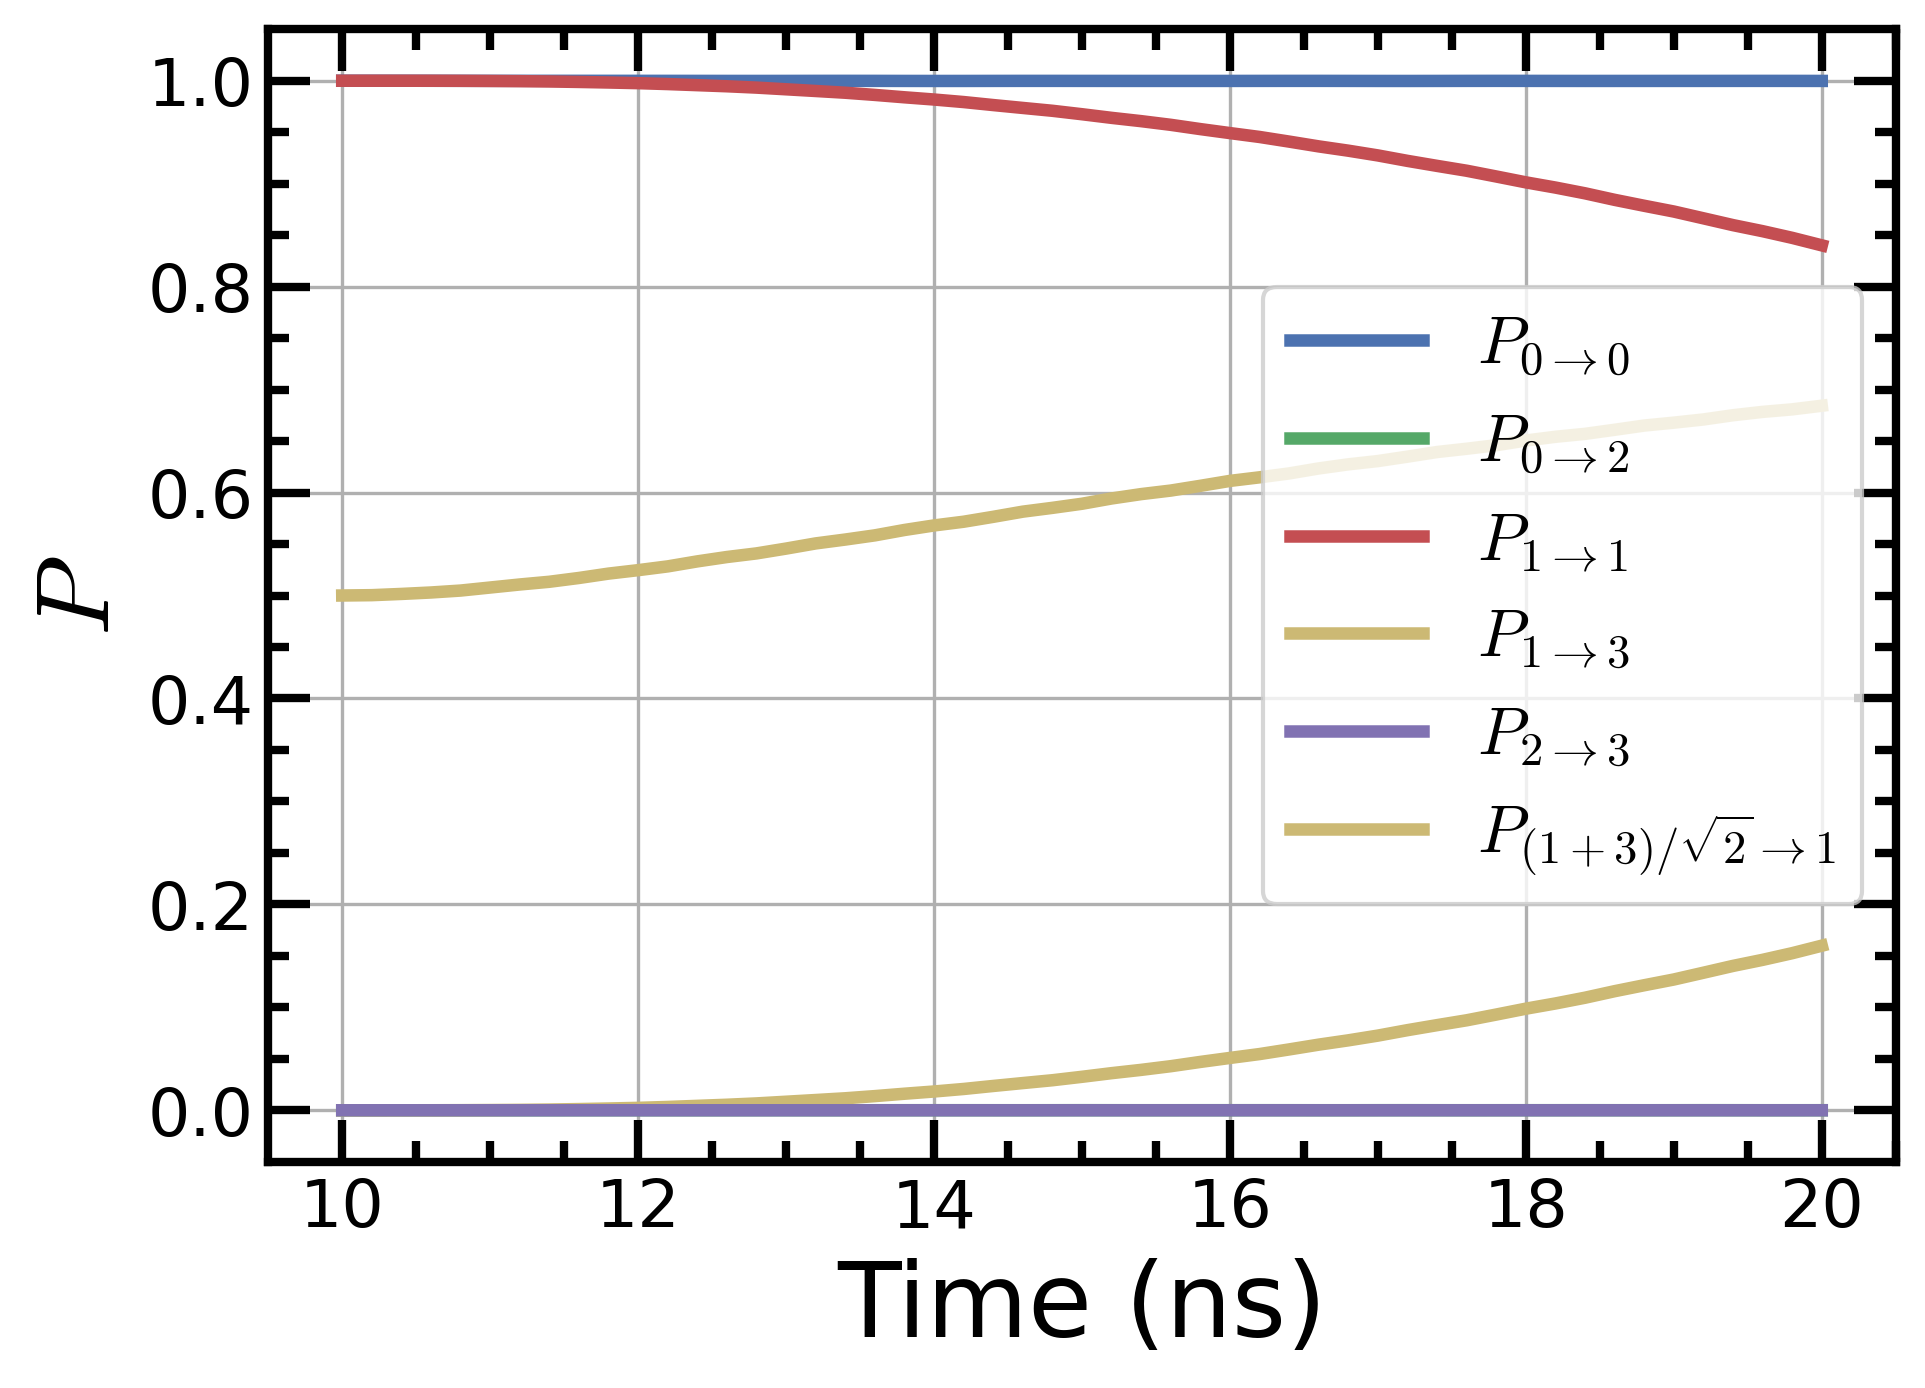

In [104]:
#Gate parameter
T_gate_13 = 10 #ns
t_points_13 = np.linspace(T_gate_02, T_gate_02+T_gate_13, 5 * int(T_gate_13) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

ini_state = 1
fin_state = 3
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_13, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_13, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_13, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_13, shape=shape, sigma=sigma, omega_d=omega_d)

trans_prob_00 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
trans_prob_23 = gates.prob_transition(U_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U_t, state_sup23, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points_13, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_13, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_13, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_13, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_13, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_13, trans_prob_sup13to1, label=r'$P_{(1+3)/\sqrt{2}\rightarrow 1}$')

plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

print (1-trans_prob_11[-1]-trans_prob_13[-1])

In [79]:
U_ideal = sigmay()
def infidelity_13(drag_coeff):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_13, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_13, shape=shape, sigma=sigma, omega_d=omega_d)
    U_f = U_nothing[-1]*U_t[-1]
    U_real = np.diag(np.zeros(2, dtype = complex))
    U_real[0,0] = U_f[1,1]
    U_real[0,1] = U_f[1,3]
    U_real[1,0] = U_f[3,1]
    U_real[1,1] = U_f[3,3]
    U_real = Qobj(U_real)

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)
print (infidelity_13(0))

0.001047516685660277


1.563205508847698e-05
0.07799284736326904


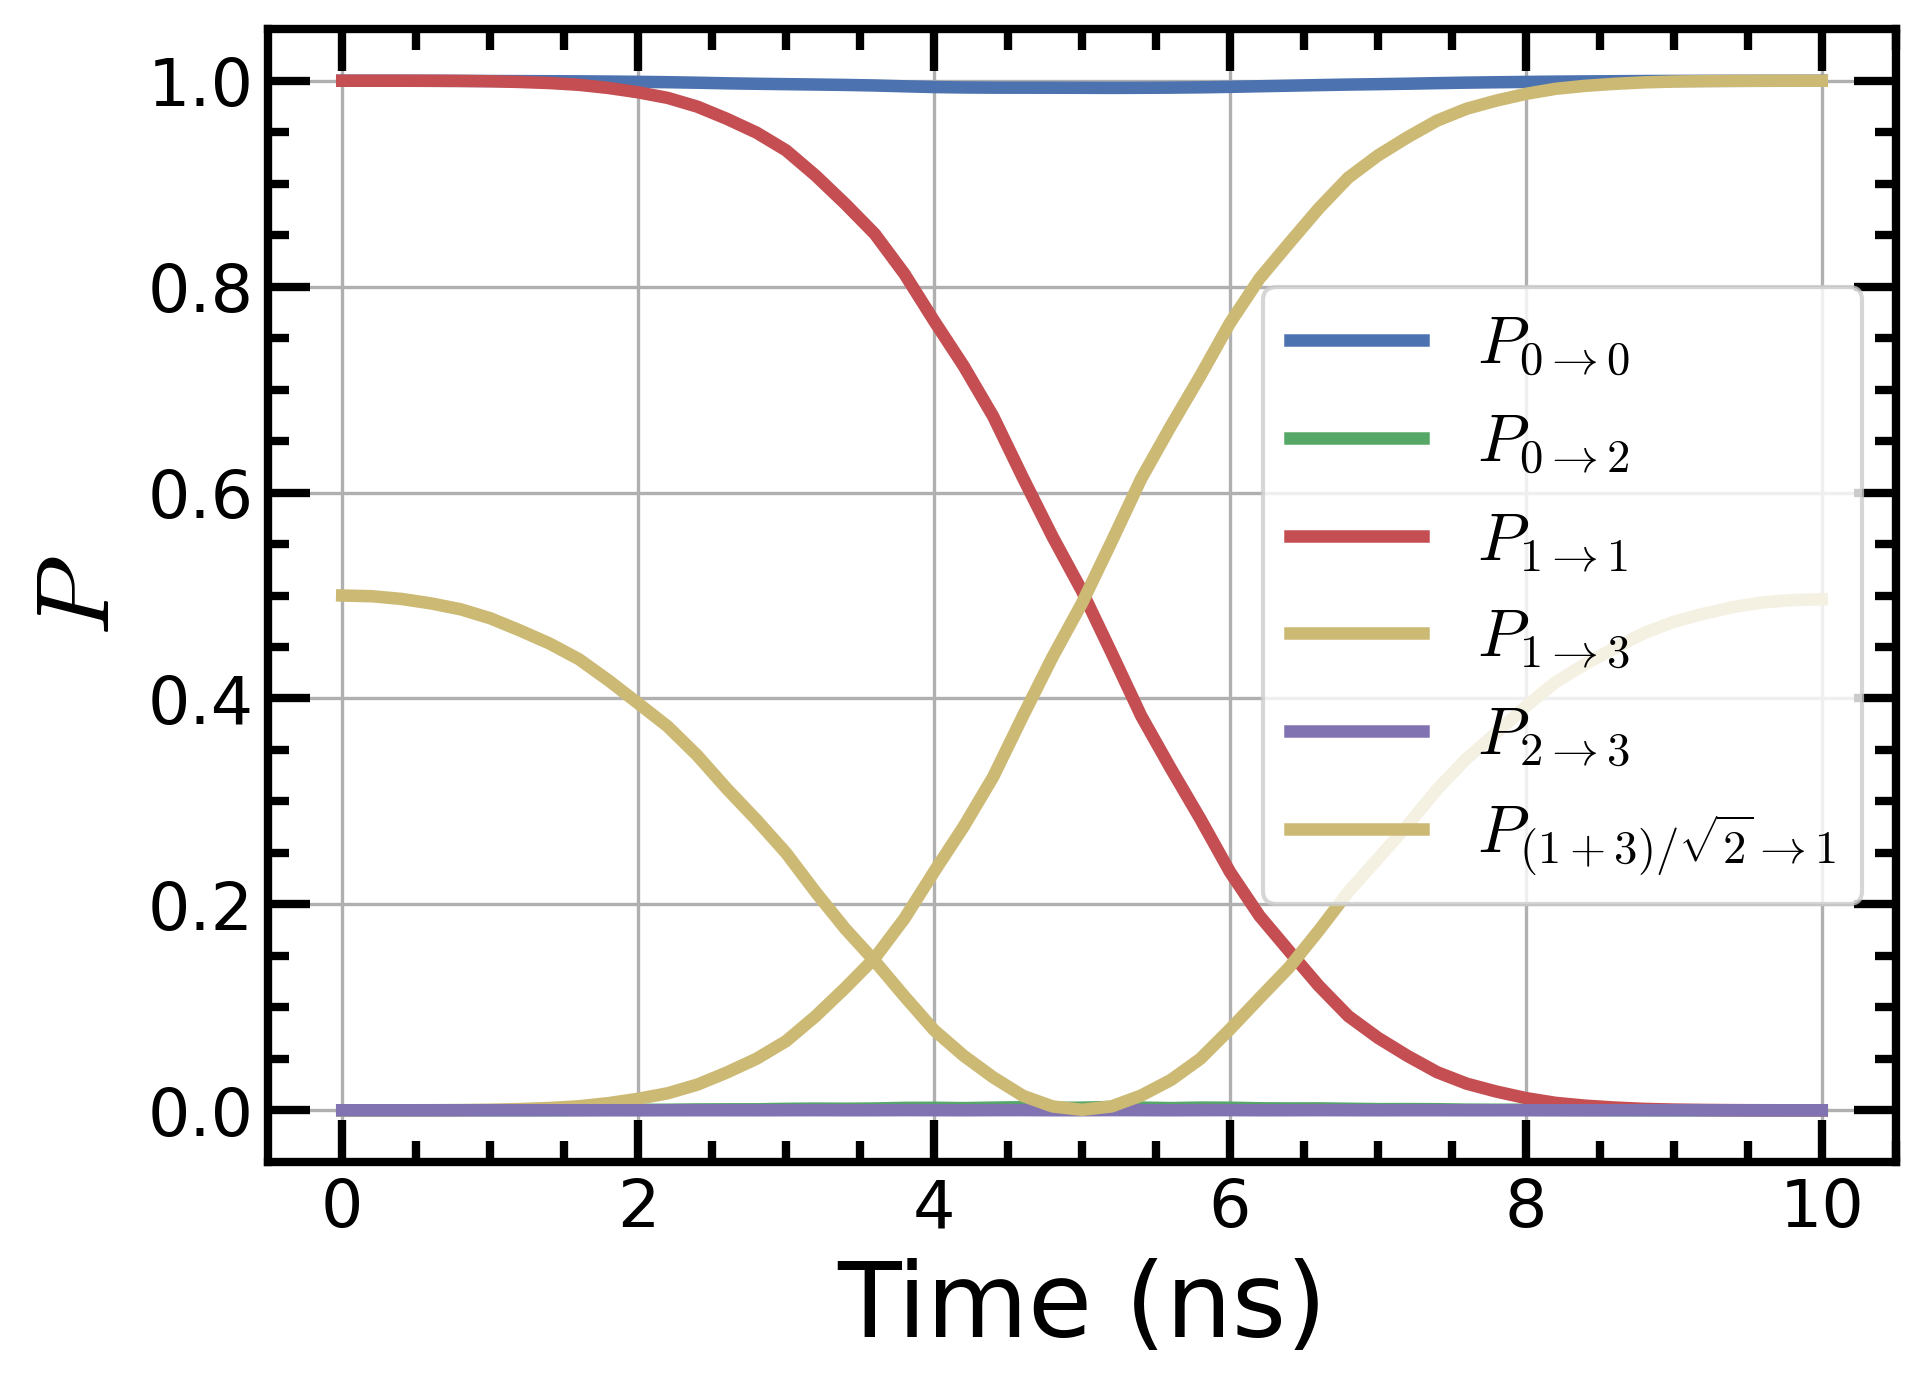

In [81]:
opt = minimize(infidelity_13, x0 = [0.0], method = 'Powell', tol = 1e-8)
print (opt.fun)
print (opt.x[0])

## Check
drag_coeff_13 = opt.x[0]
ini_state = 1
fin_state = 3
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U13_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_13, DRAG = drag, DRAG_coefficient = drag_coeff_13,
                T_gate=T_gate_13, shape=shape, sigma=sigma, omega_d=omega_d)


trans_prob_00 = gates.prob_transition(U13_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U13_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U13_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U13_t, state_1, state_3)
trans_prob_23 = gates.prob_transition(U13_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U13_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U13_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U13_t, state_sup23, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points_13, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_13, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_13, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_13, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_13, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_13, trans_prob_sup13to1, label=r'$P_{(1+3)/\sqrt{2}\rightarrow 1}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

### 2-3 transition

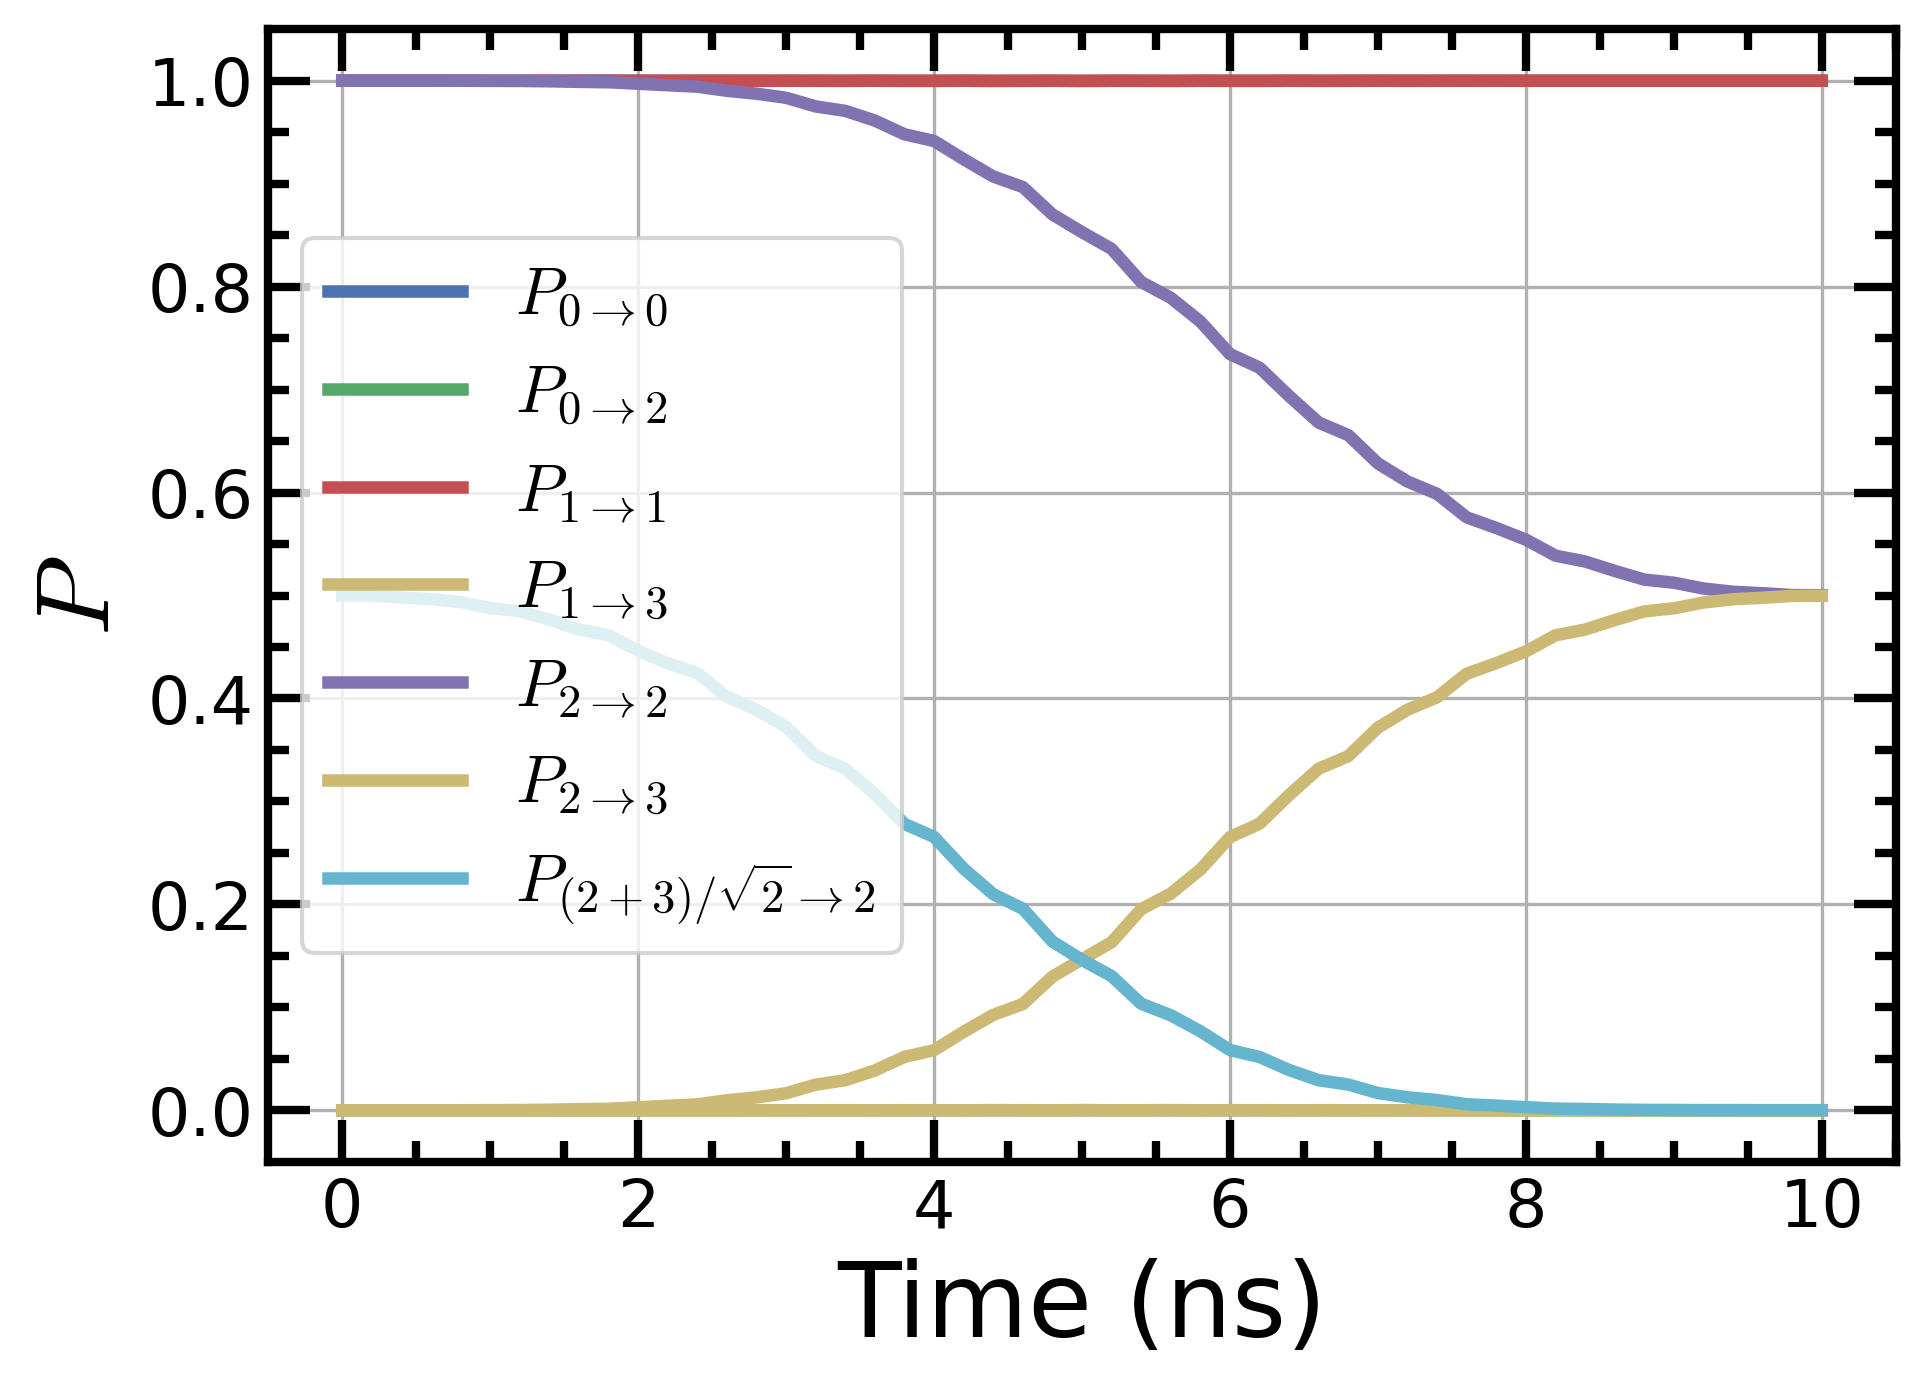

In [82]:
#Gate parameter
T_gate_23 = 10 #ns
t_points_23 = np.linspace(0, T_gate_23, 5 * int(T_gate_23) + 1)
drive_amplitude_factor = 0.25
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

ini_state = 2
fin_state = 3
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)

trans_prob_00 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
trans_prob_22 = gates.prob_transition(U_t, state_2, state_2)
trans_prob_23 = gates.prob_transition(U_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U_t, state_sup23, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points_23, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_23, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_23, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_23, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_23, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.plot(t_points_23, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_23, trans_prob_sup23to2, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

In [83]:
U_ideal = ry(phi=np.pi/2)
def infidelity_23(drag_coeff):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)
    U_f = U_nothing[-1]*U_t[-1]
    U_real = np.diag(np.zeros(2, dtype = complex))
    U_real[0,0] = U_f[2,2]
    U_real[0,1] = U_f[2,3]
    U_real[1,0] = U_f[3,2]
    U_real[1,1] = U_f[3,3]
    U_real = Qobj(U_real)

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)
print (infidelity_23(0))

0.00018801529509338


<ipython-input-83-9bd096b2831b>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = ry(phi=np.pi/2)


1.7641156868641872e-08
-0.10540068841319956


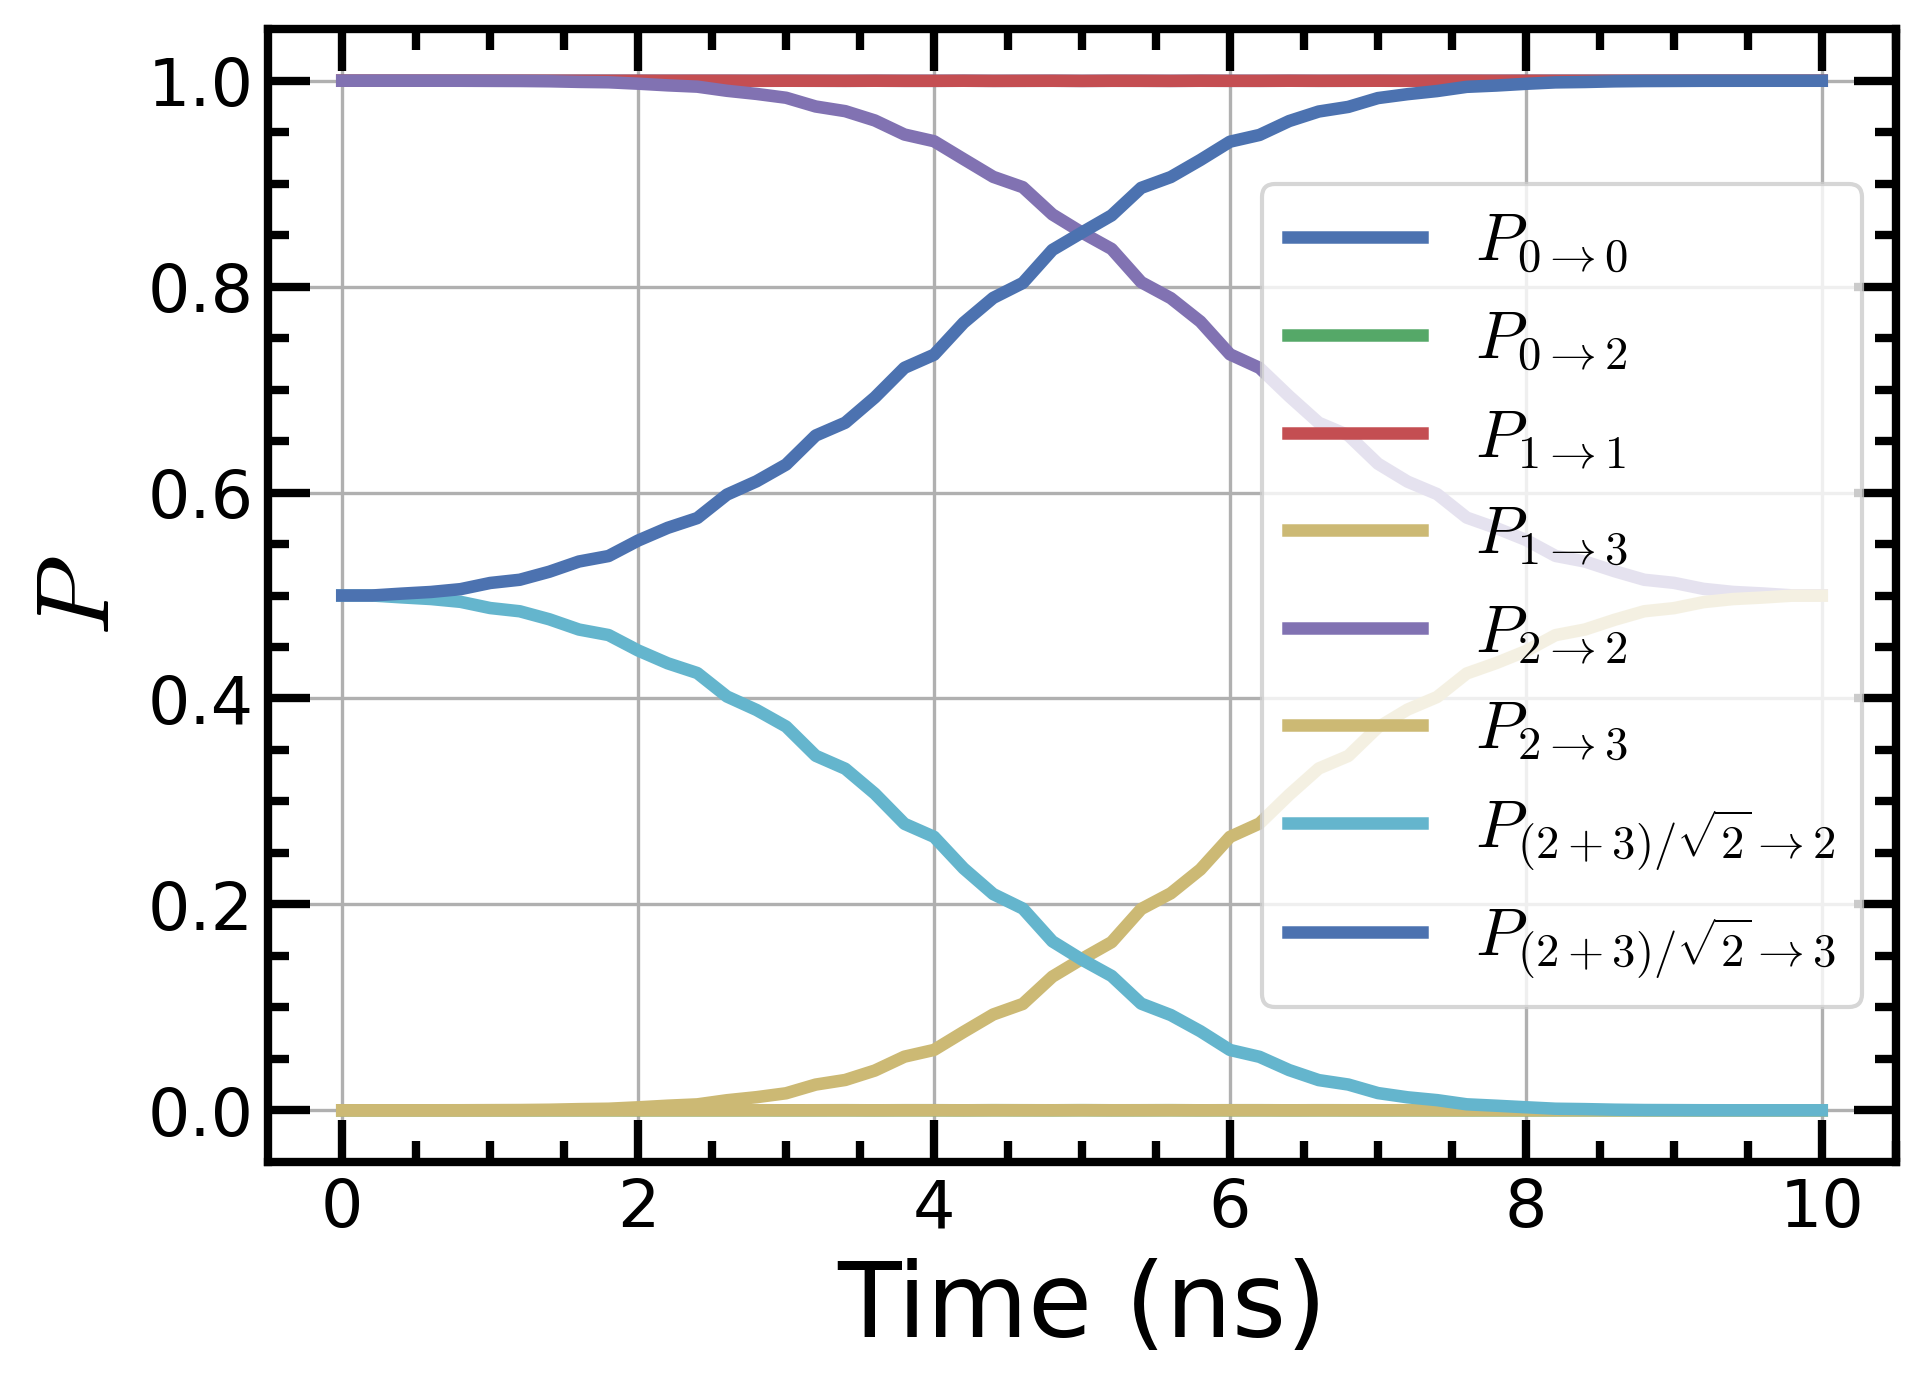

In [84]:
opt = minimize(infidelity_23, x0 = [0.0], method ='Powell', tol = 1e-6)
print (opt.fun)
print (opt.x[0])

## Check
drag_coeff_23 = opt.x[0]
ini_state = 2
fin_state = 3
comp_space = [ini_state,fin_state]
omega_d = qubit.freq(ini_state,fin_state) + delta_omega_d
matr_el = np.abs(qubit.n_ij(ini_state,fin_state))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U23_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff_23,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)


trans_prob_00 = gates.prob_transition(U23_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U23_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U23_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U23_t, state_1, state_3)
trans_prob_22 = gates.prob_transition(U23_t, state_2, state_2)
trans_prob_23 = gates.prob_transition(U23_t, state_2, state_3)

trans_prob_sup02to0 = gates.prob_transition(U23_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U23_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U23_t, state_sup23, state_2)
trans_prob_sup23to3 = gates.prob_transition(U23_t, state_sup23, state_3)

plt.figure(figsize = [7,5])
plt.plot(t_points_23, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points_23, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points_23, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points_23, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points_23, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.plot(t_points_23, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points_23, trans_prob_sup23to2, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 2}$')
plt.plot(t_points_23, trans_prob_sup23to3, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 3}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

## Combine the gates together

<ipython-input-133-43c542f7130b>:6: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sx2 = rx(np.pi/2)
<ipython-input-133-43c542f7130b>:7: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sy2 = ry(np.pi/2)
<ipython-input-133-43c542f7130b>:11: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  gate = ry(np.pi/2)
<ipython-input-133-43c542f7130b>:20: FutureWarning: `rcond` parameter will

(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8705e3e520>)

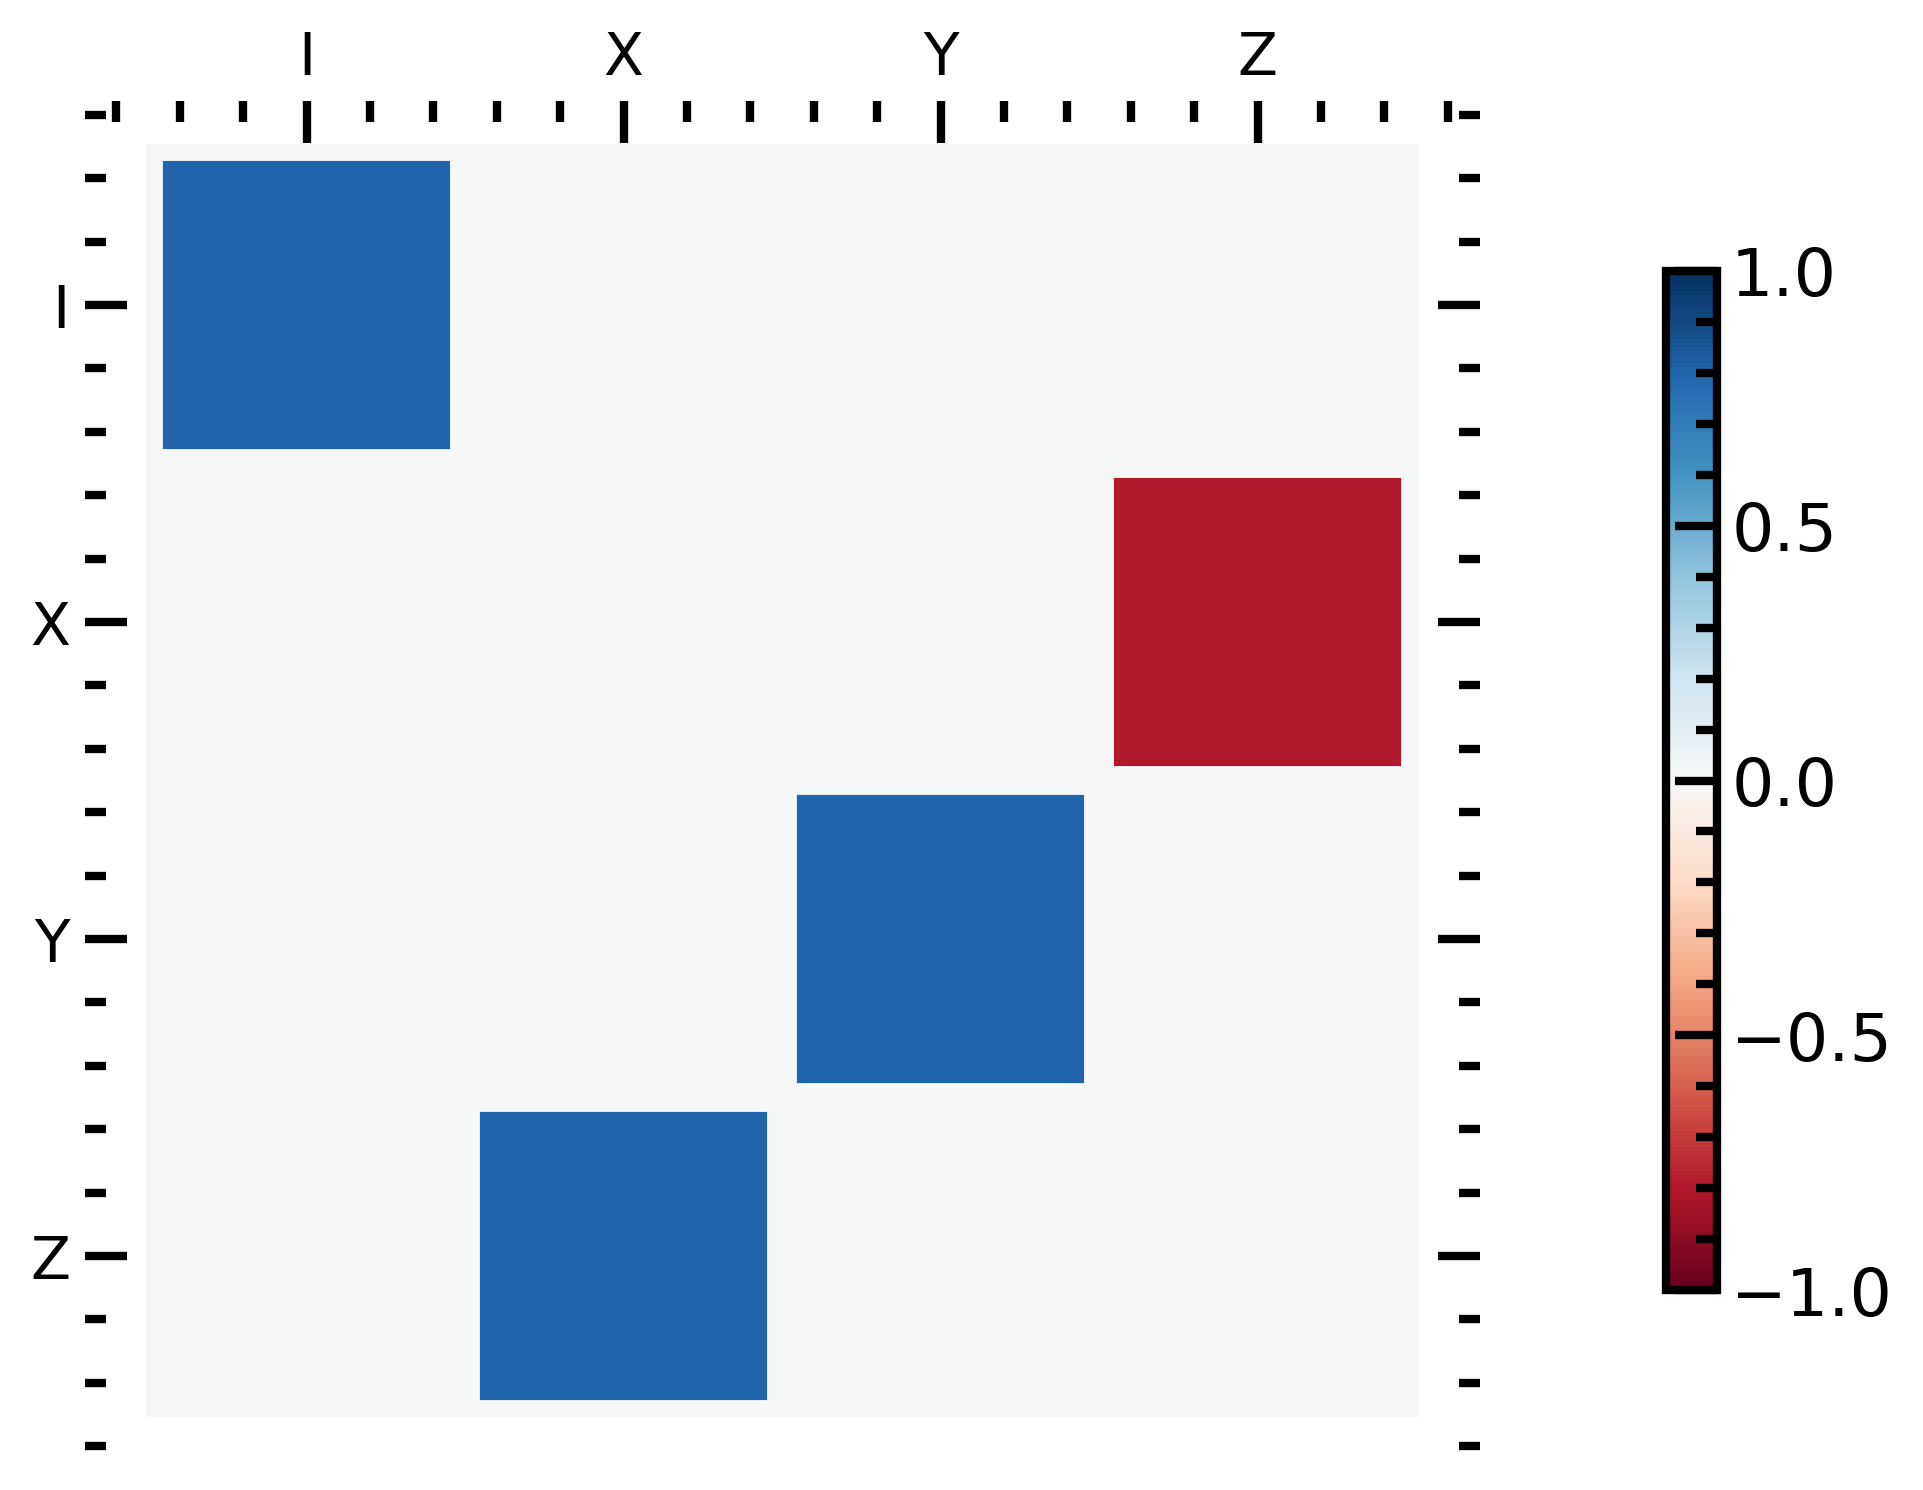

In [133]:
#Look at ideal case
I = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sx2 = rx(np.pi/2)
sy2 = ry(np.pi/2)
p_in = np.zeros((4,4))
p_out = np.zeros((4,4))

gate = ry(np.pi/2)

prep_rotations = [I, sx, sx2, sy2]
meas_rotations = [I, sx, sy, sz]
for i, prep in enumerate(prep_rotations):
    for j, meas in enumerate(meas_rotations):
        p_in[i,j] = expect(meas, prep*basis(2,0))
        p_out[i,j] = expect(meas, gate*prep*basis(2,0))
        
ptm_ideal =  Qobj(np.linalg.lstsq(p_out, p_in)[0]     ) 
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)

<ipython-input-112-7d52c7704ec4>:9: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_2[2,2] = ry(np.pi/2).data[0,0]
<ipython-input-112-7d52c7704ec4>:10: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_2[2,3] = ry(np.pi/2).data[0,1]
<ipython-input-112-7d52c7704ec4>:11: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_2[3,2] = ry(np.pi/2).data[1,0]
<ipython-input-112-7d52c7704e

(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f871e874400>)

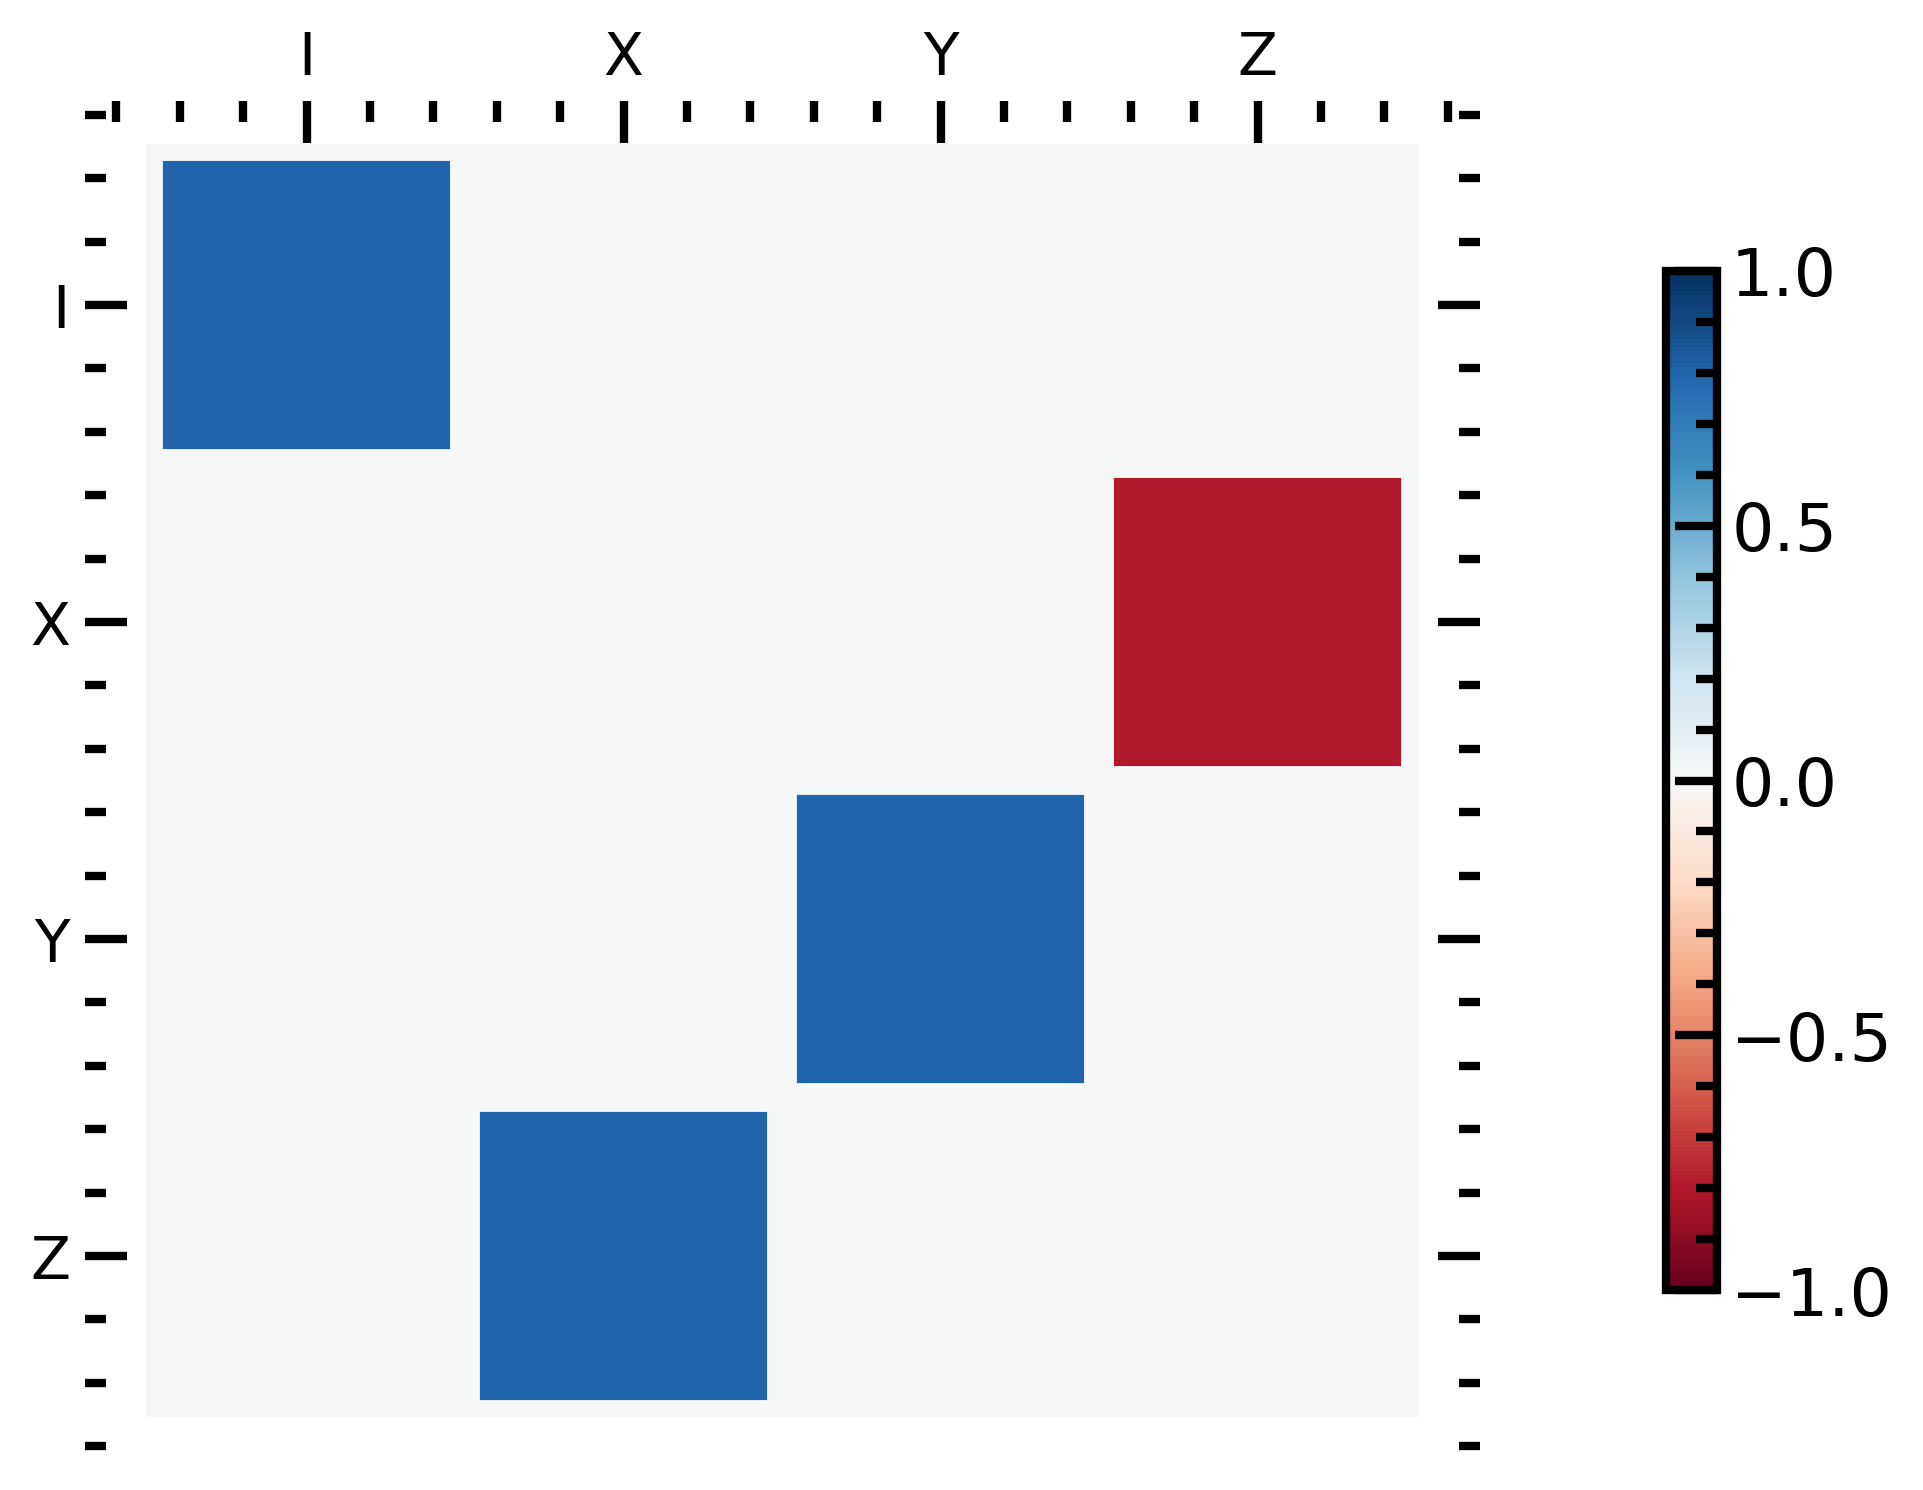

In [112]:
#Checking using unitary matrix of a multi-level qubit
U_1 = np.diag(np.zeros(nlev_single, dtype = complex))
U_2 = np.diag(np.zeros(nlev_single, dtype = complex))
U_1[0,2] = -1j
U_1[2,0] = 1j
U_1[1,3] = -1j
U_1[3,1] = 1j
U_1 = Qobj(U_1)
U_2[2,2] = ry(np.pi/2).data[0,0]
U_2[2,3] = ry(np.pi/2).data[0,1]
U_2[3,2] = ry(np.pi/2).data[1,0]
U_2[3,3] = ry(np.pi/2).data[1,1]
U_2 = Qobj(U_2)

for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    psi_fin = U_1*U_2*U_1*psi_ini
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, psi_fin))
        
ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])       
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)  

<ipython-input-93-46ff52ec5154>:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8714b0fa60>)

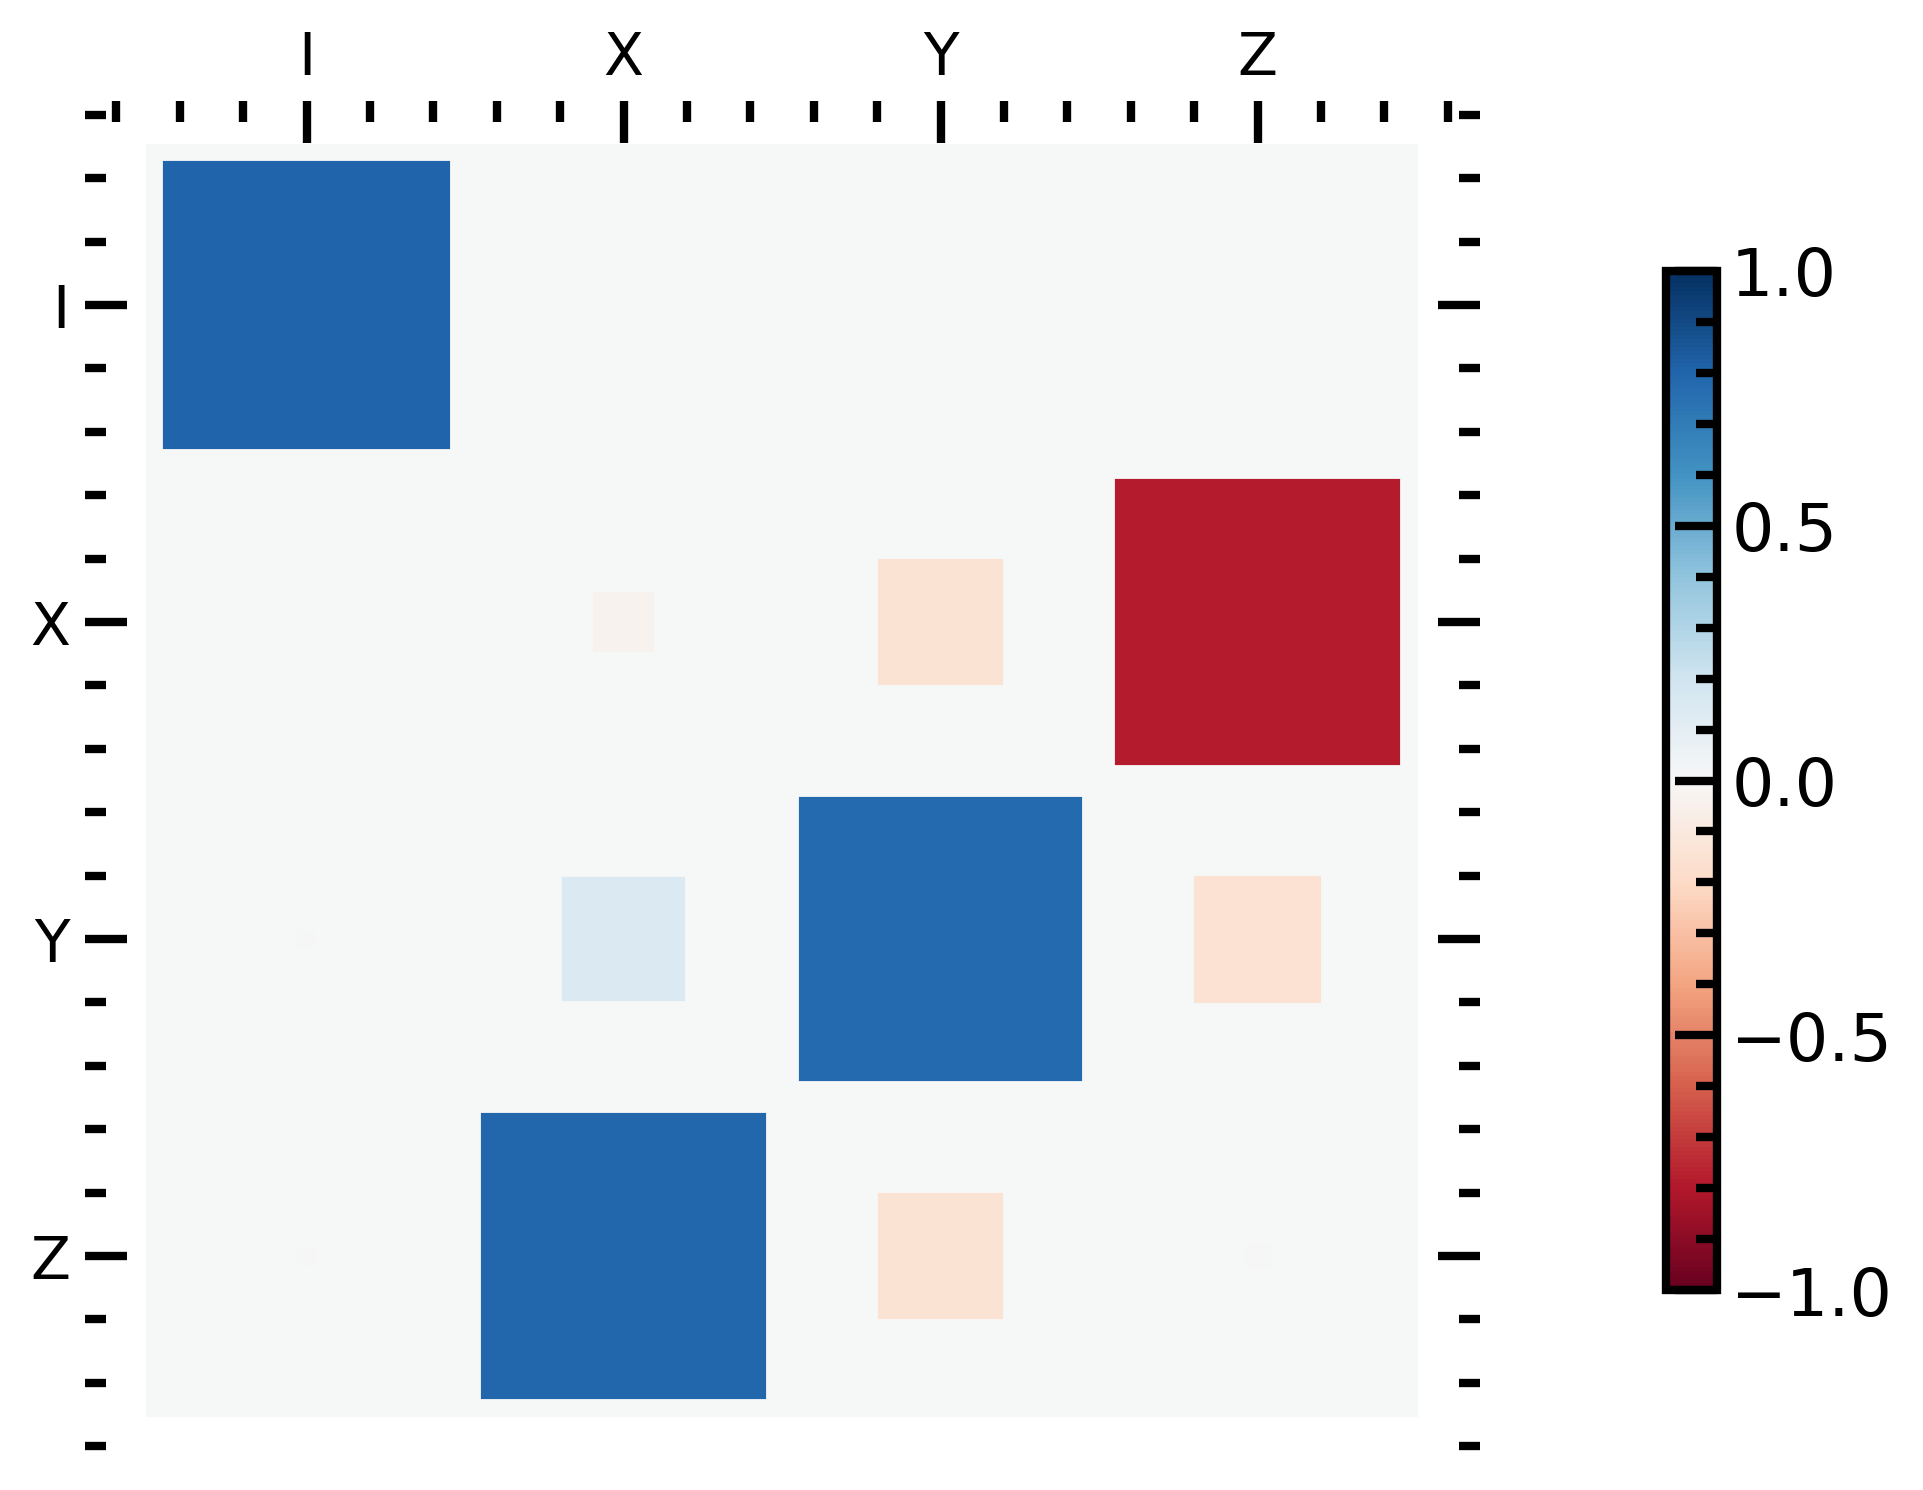

In [93]:
prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)


for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    psi_fin = U_nothing[-1]*U02_t[-1]*psi_ini   
    psi_fin = U_nothing[-1]*U13_t[-1]*psi_fin
    psi_fin = U_nothing[-1]*U23_t[-1]*psi_fin
    psi_fin = U_nothing[-1]*U13_t[-1]*psi_fin
    psi_fin = U_nothing[-1]*U02_t[-1]*psi_fin
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, psi_fin))
        
ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])       
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)       

# Applying two drives at the same time

-22.270865380811568


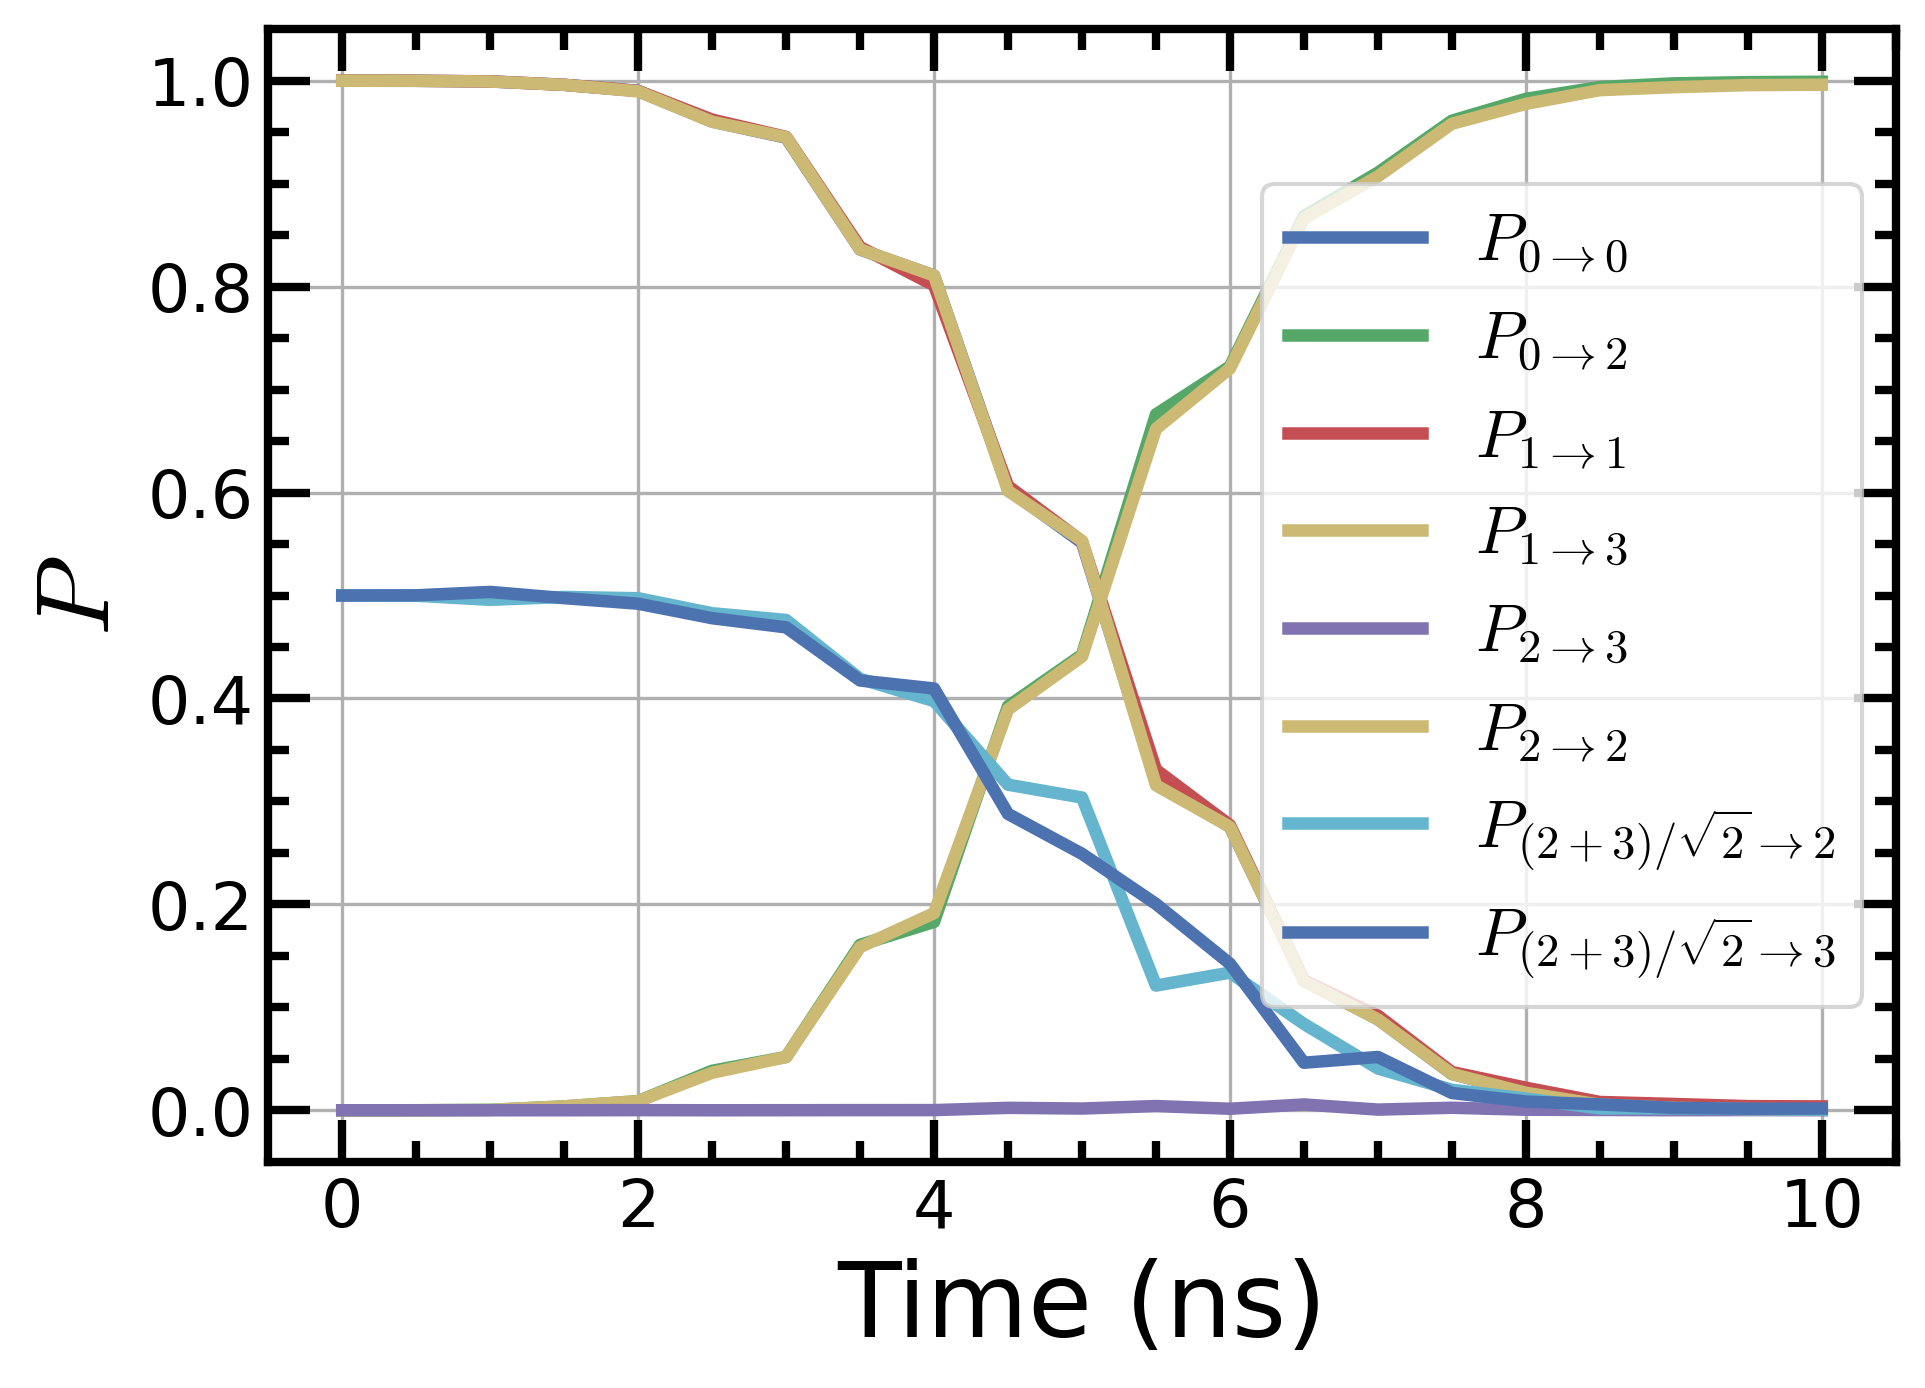

In [115]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d1 = 0
delta_omega_d2 = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = -0.0034568125403369636
drag_coeff_ratio =  -0.07799284736326904 / 0.0035020124287791334
print(-0.07799284736326904 / 0.0035020124287791334)

ini_state1 = 0
fin_state1 = 2
omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
matr_el_1 = np.abs(qubit.n_ij(ini_state1,fin_state1))

ini_state2 = 1
fin_state2 = 3
omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
matr_el_2 = np.abs(qubit.n_ij(ini_state2,fin_state2))

epsilon = drive_amplitude_factor/matr_el_1
drive_ratio = matr_el_1/matr_el_2

H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
U_nothing = gates_double.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)

trans_prob_00 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
trans_prob_22 = gates.prob_transition(U_t, state_2, state_2)
trans_prob_23 = gates.prob_transition(U_t, state_2, state_3)
trans_prob_sup02to0 = gates.prob_transition(U_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U_t, state_sup23, state_2)
trans_prob_sup23to3 = gates.prob_transition(U_t, state_sup23, state_3)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.plot(t_points, trans_prob_sup23to2, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 2}$')
plt.plot(t_points, trans_prob_sup23to3, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 3}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

In [116]:
def infidelity_02(drag_coeff):
    U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    U_f = U_nothing[-1]*U_t[-1]
    U_real = np.diag(np.zeros(2, dtype = complex))
    U_real[0,0] = U_f[0,0]
    U_real[0,1] = U_f[0,2]
    U_real[1,0] = U_f[2,0]
    U_real[1,1] = U_f[2,2]
    U_real = Qobj(U_real)

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)

def infidelity_13(drag_coeff, drag_coeff_ratio):
    U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    U_f = U_nothing[-1]*U_t[-1]
    U_real = np.diag(np.zeros(2, dtype = complex))
    U_real[0,0] = U_f[1,1]
    U_real[0,1] = U_f[1,3]
    U_real[1,0] = U_f[3,1]
    U_real[1,1] = U_f[3,3]
    U_real = Qobj(U_real)

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)

print (infidelity_02(0))
print (infidelity_13(0,1))
print (infidelity_02(-0.0034568125403369636))
print (infidelity_13(-0.0034568125403369636, -23))

0.000741771555708759
0.006361966111518846
0.000681634429043565
0.0024968009768464583


In [29]:
## It appears that individual tuning of the gates do not give the best results. 
#So now, we tune them both at the same time.

U_ideal = sigmay()
def leakage_0213(x):
    drive_ratio = x[0]
    drag_coeff = x[1]
    delta_omega_d1 = x[2]
    delta_omega_d2 = x[3]
    drag_coeff_ratio = x[4]
    omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
    omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
    U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
    trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
    return 2 - trans_prob_02[-1] - trans_prob_13[-1]

def infidelity_0213(x):
    drag_coeff = x[0]
    delta_omega_d1 = x[1]
    delta_omega_d2 = x[2]
    drag_coeff_ratio = x[3]
    omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
    omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
    U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    U_f = U_nothing[-1]*U_t[-1]
    U_real_02 = np.diag(np.zeros(2, dtype = complex))
    U_real_13 = np.diag(np.zeros(2, dtype = complex))
    U_real_02[0,0] = U_f[0,0]
    U_real_02[0,1] = U_f[0,2]
    U_real_02[1,0] = U_f[2,0]
    U_real_02[1,1] = U_f[2,2]
    U_real_02 = Qobj(U_real_02)
    U_real_13[0,0] = U_f[1,1]
    U_real_13[0,1] = U_f[1,3]
    U_real_13[1,0] = U_f[3,1]
    U_real_13[1,1] = U_f[3,3]
    U_real_13 = Qobj(U_real_13)

    op1_02 = U_real_02.dag() * U_real_02
    op2_02 = U_real_02 * U_ideal.dag()
    fidel_02 = (op1_02.tr() + (abs(op2_02.tr())) ** 2) / 6.0
    op1_13 = U_real_13.dag() * U_real_13
    op2_13 = U_real_13 * U_ideal.dag()
    fidel_13 = (op1_13.tr() + (abs(op2_13.tr())) ** 2) / 6.0

    return abs(1 - fidel_02*fidel_13)

opt0213 = minimize(infidelity_0213, x0 = [0,0,0,-20], method ='Powell', tol = 1e-6)
print (opt0213.fun)
print (opt0213.x)

0.0005304743098955012
[-5.16071264e-02  1.13019024e-06 -2.19682305e-05 -3.93361902e+00]


0.0002912153439567078
0.0002393286621334978


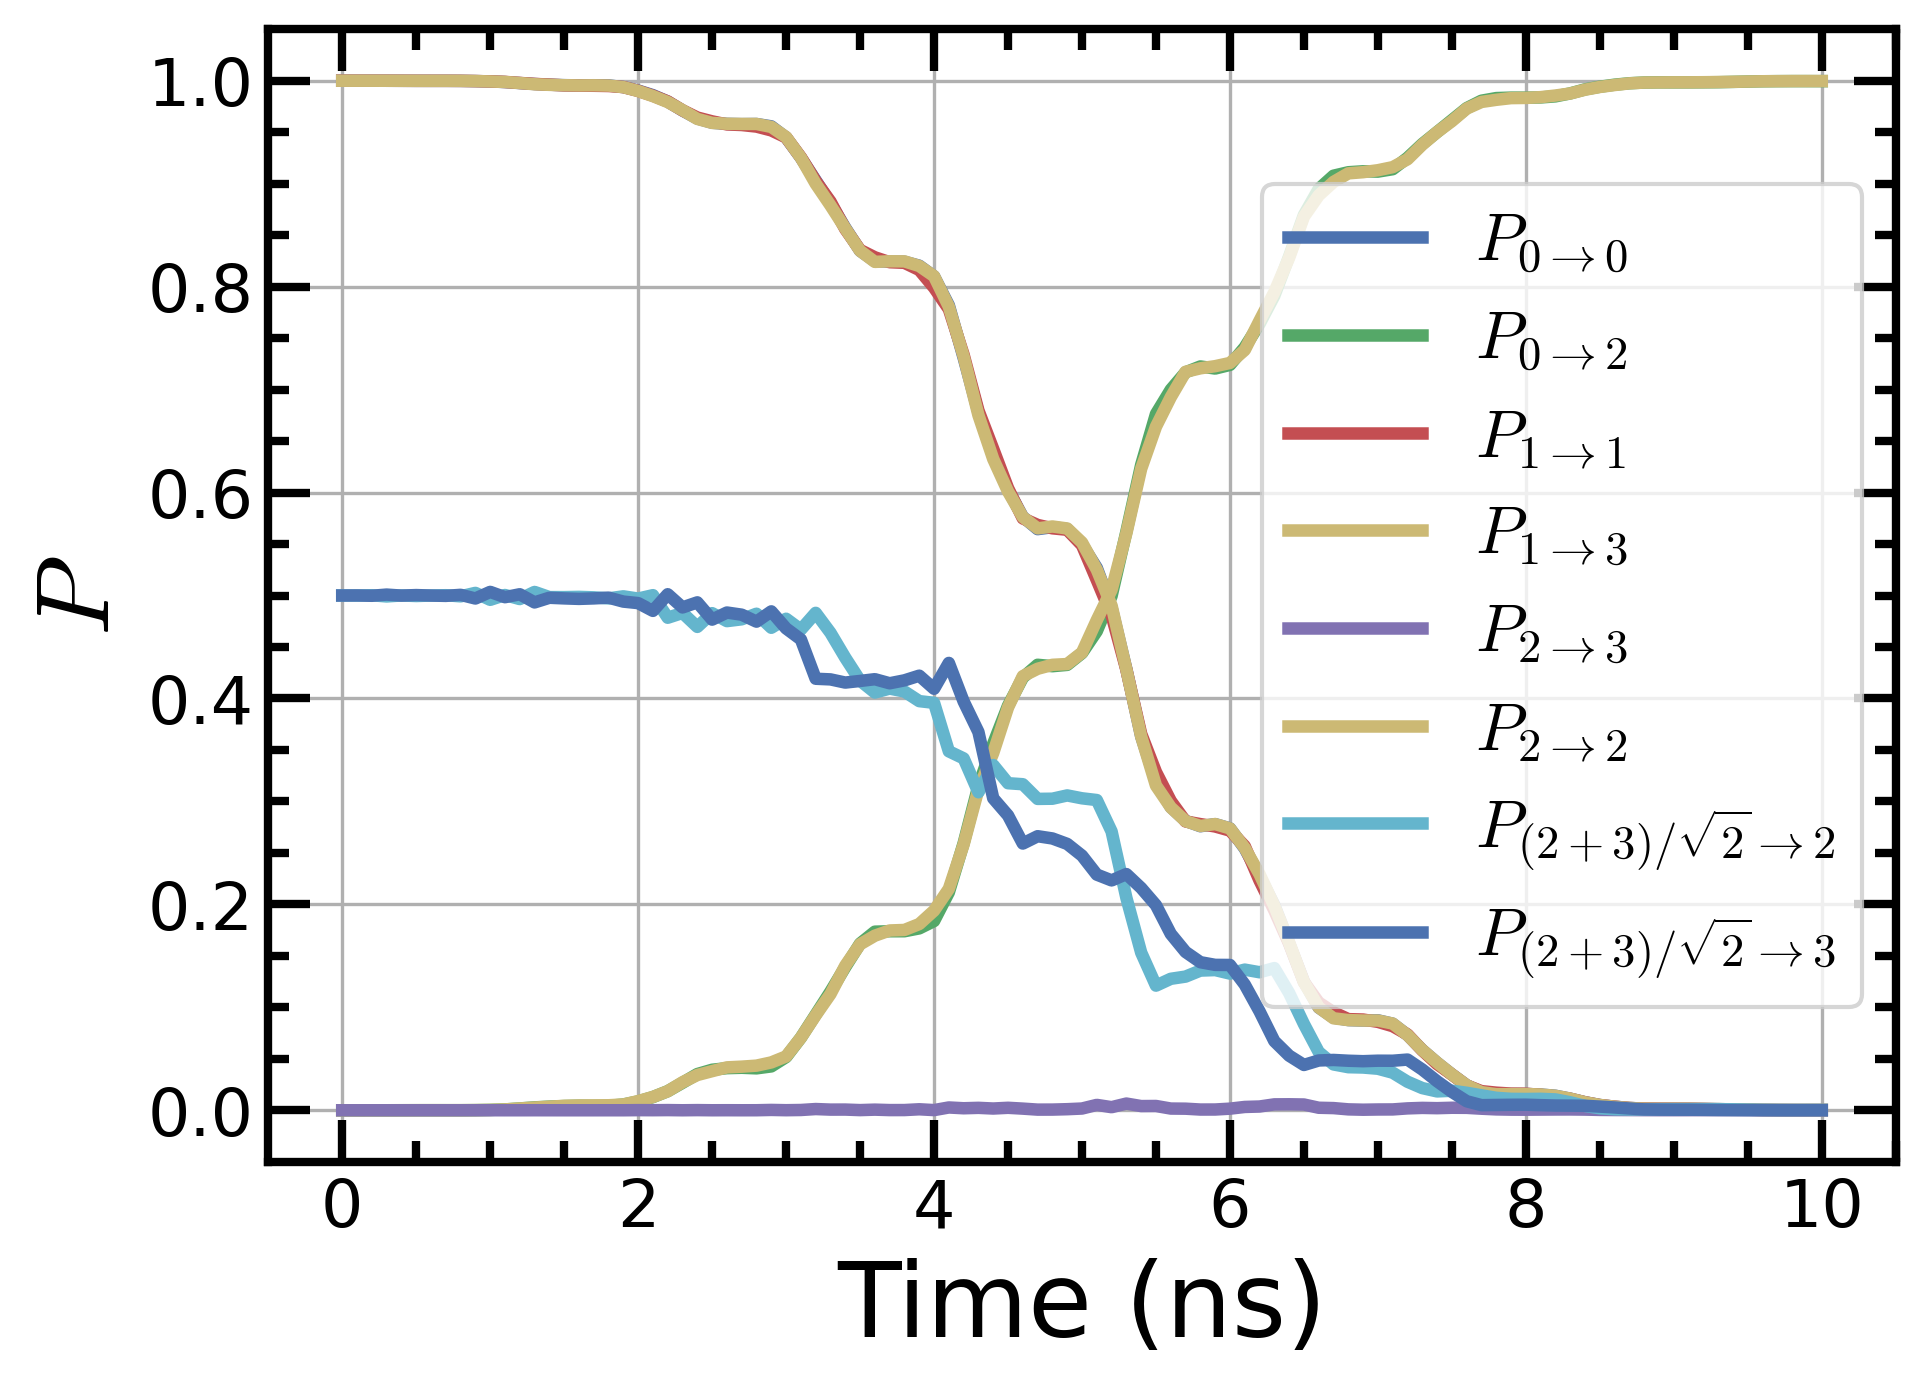

In [109]:
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor_02 = 0.5
drag_coeff_02,delta_omega_d1,delta_omega_d2,drag_coeff_ratio = opt0213.x

shape = 'gauss'
sigma = 0.25
drag = True

ini_state1 = 0
fin_state1 = 2
omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
matr_el_1 = np.abs(qubit.n_ij(ini_state1,fin_state1))

ini_state2 = 1
fin_state2 = 3
omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
matr_el_2 = np.abs(qubit.n_ij(ini_state2,fin_state2))
epsilon = drive_amplitude_factor_02/matr_el_1

H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)

U_f = U_nothing[-1]*U_t[-1]
U_real_02 = np.diag(np.zeros(2, dtype = complex))
U_real_13 = np.diag(np.zeros(2, dtype = complex))
U_real_02[0,0] = U_f[0,0]
U_real_02[0,1] = U_f[0,2]
U_real_02[1,0] = U_f[2,0]
U_real_02[1,1] = U_f[2,2]
U_real_02 = Qobj(U_real_02)
U_real_13[0,0] = U_f[1,1]
U_real_13[0,1] = U_f[1,3]
U_real_13[1,0] = U_f[3,1]
U_real_13[1,1] = U_f[3,3]
U_real_13 = Qobj(U_real_13)

op1_02 = U_real_02.dag() * U_real_02
op2_02 = U_real_02 * U_ideal.dag()
fidel_02 = (op1_02.tr() + (abs(op2_02.tr())) ** 2) / 6.0
op1_13 = U_real_13.dag() * U_real_13
op2_13 = U_real_13 * U_ideal.dag()
fidel_13 = (op1_13.tr() + (abs(op2_13.tr())) ** 2) / 6.0

print (1-fidel_02)
print (1-fidel_13)

trans_prob_00 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_02 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_11 = gates.prob_transition(U_t, state_1, state_1)
trans_prob_13 = gates.prob_transition(U_t, state_1, state_3)
trans_prob_22 = gates.prob_transition(U_t, state_2, state_2)
trans_prob_23 = gates.prob_transition(U_t, state_2, state_3)
trans_prob_sup02to0 = gates.prob_transition(U_t, state_sup02, state_0)
trans_prob_sup13to1 = gates.prob_transition(U_t, state_sup13, state_1)
trans_prob_sup23to2 = gates.prob_transition(U_t, state_sup23, state_2)
trans_prob_sup23to3 = gates.prob_transition(U_t, state_sup23, state_3)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_00, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_02, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_11, label=r'$P_{1\rightarrow 1}$')
plt.plot(t_points, trans_prob_13, color = 'C4', label=r'$P_{1\rightarrow 3}$')
plt.plot(t_points, trans_prob_23, label=r'$P_{2\rightarrow 3}$')
plt.plot(t_points, trans_prob_22, label=r'$P_{2\rightarrow 2}$')
plt.plot(t_points, trans_prob_sup23to2, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 2}$')
plt.plot(t_points, trans_prob_sup23to3, label=r'$P_{(2+3)/\sqrt{2}\rightarrow 3}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()

In [ ]:
T_gate_array = np.linspace(5,50,10)
error_array = np.zeros_like(T_gate_array)
for idx, T_gate in enumerate(T_gate_array):
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    
    def infidelity_0213(x):
    drive_ratio = x[0]
    drag_coeff = x[1]
    delta_omega_d1 = x[2]
    delta_omega_d2 = x[3]
    drag_coeff_ratio = x[4]
    omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
    omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
    U_t = gates_double.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    U_f = U_nothing[-1]*U_t[-1]
    U_real_02 = np.diag(np.zeros(2, dtype = complex))
    U_real_13 = np.diag(np.zeros(2, dtype = complex))
    U_real_02[0,0] = U_f[0,0]
    U_real_02[0,1] = U_f[0,2]
    U_real_02[1,0] = U_f[2,0]
    U_real_02[1,1] = U_f[2,2]
    U_real_02 = Qobj(U_real_02)
    U_real_13[0,0] = U_f[1,1]
    U_real_13[0,1] = U_f[1,3]
    U_real_13[1,0] = U_f[3,1]
    U_real_13[1,1] = U_f[3,3]
    U_real_13 = Qobj(U_real_13)

    op1 = U_real_02.dag() * U_real_02
    op2 = U_real_02 * U_ideal.dag()
    fidel_02 = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    op1 = U_real_13.dag() * U_real_13
    op2 = U_real_13 * U_ideal.dag()
    fidel_13 = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0

    return abs(1 - fidel_02*fidel_13)

    opt0213 = minimize(infidelity_0213, x0 = [matr_el_1/matr_el_2,0,0,0,1], method ='Powell', tol = 1e-8)
    error_array[idx] = opt0213.fun

## Combined, use state vectors

(-0.1, 1.1)

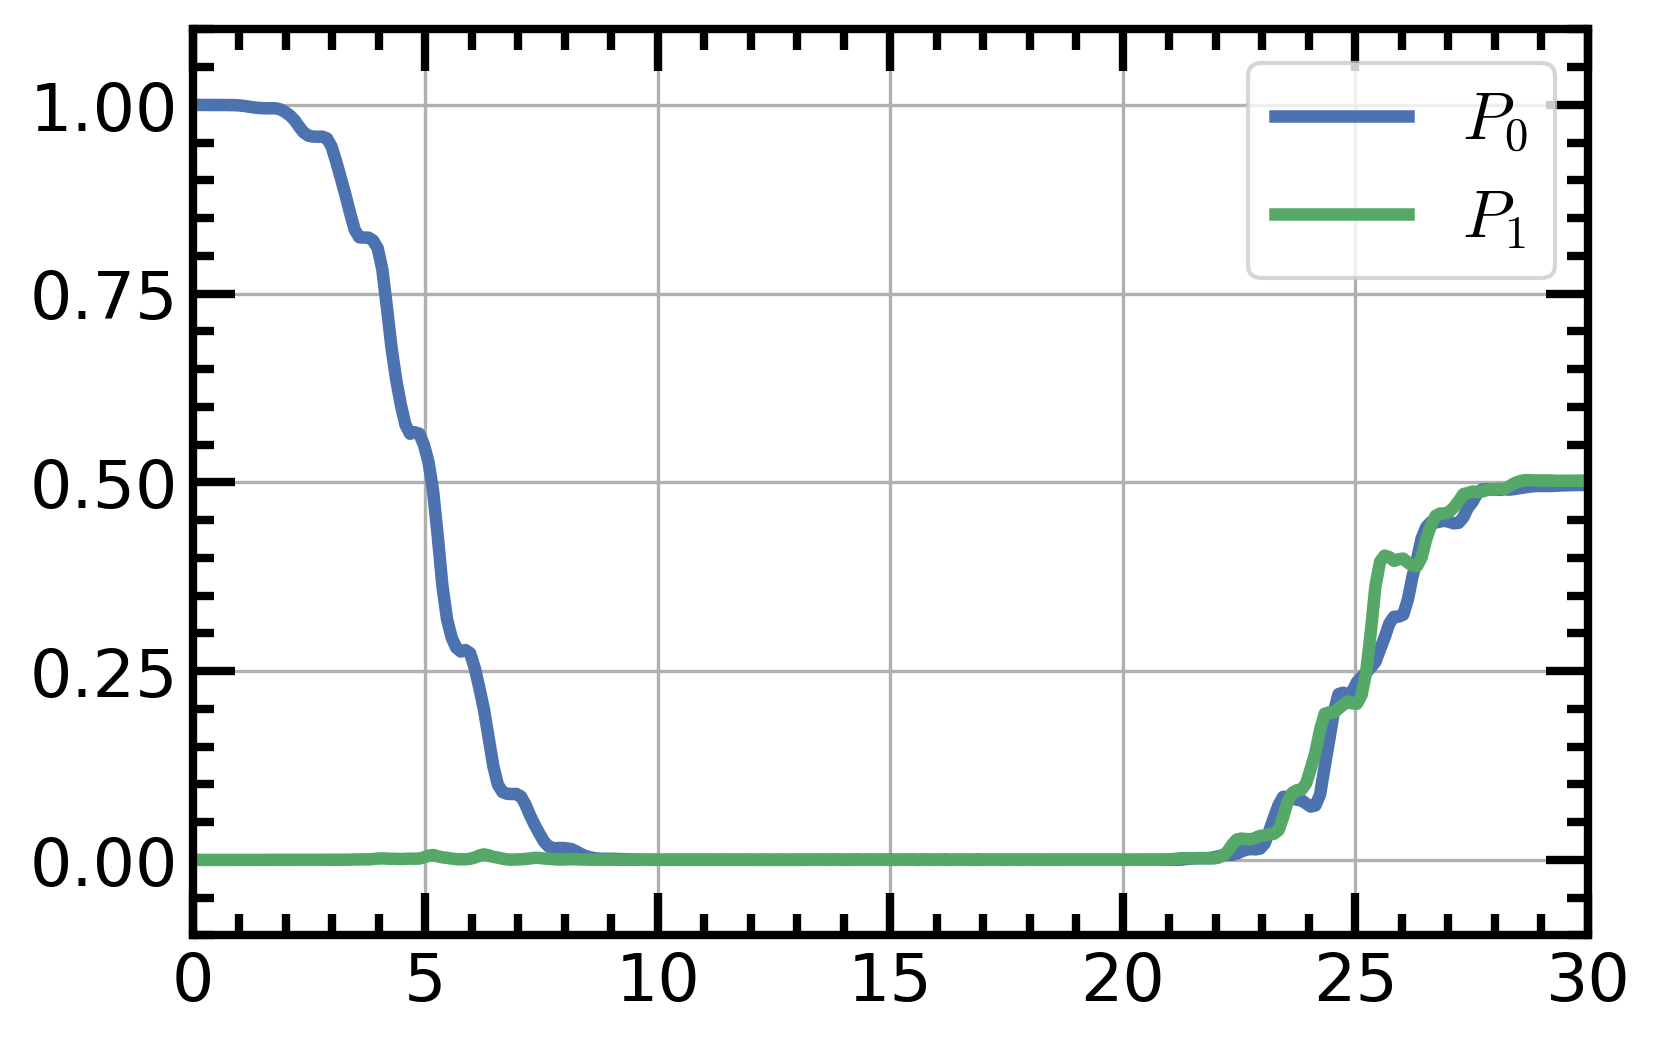

In [118]:
#First pulse
T_gate_02 = 10 #ns
t_points_02 = np.linspace(0, T_gate_02, 10 * int(T_gate_02) + 1)
drive_amplitude_factor_02 = 0.5
# drive_ratio,drag_coeff_02,delta_omega_d1,delta_omega_d2,drag_coeff_ratio =[ 1.06949707e+00, -2.61610930e-02,  9.07668388e-03,  7.40791843e-03,
#   1.01133428e+01] 
drag_coeff_02,delta_omega_d1,delta_omega_d2,drag_coeff_ratio = opt0213.x
shape = 'gauss'
sigma = 0.25
drag = True

ini_state1 = 0
fin_state1 = 2
omega_d_1 = qubit.freq(ini_state1,fin_state1) + delta_omega_d1
matr_el_1 = np.abs(qubit.n_ij(ini_state1,fin_state1))

ini_state2 = 1
fin_state2 = 3
omega_d_2 = qubit.freq(ini_state2,fin_state2) + delta_omega_d2
matr_el_2 = np.abs(qubit.n_ij(ini_state2,fin_state2))
epsilon_02 = drive_amplitude_factor_02/matr_el_1

H_drive_02 = epsilon_02*(qubit.n())
H_dummy = 0*(qubit.n())

#Second pulse parameters
T_gate_23 = 10 #ns
t_points_23 = np.linspace(0, T_gate_23, 10 * int(T_gate_23) + 1)
drive_amplitude_factor_23 = 0.25
delta_omega_d_23 = 0
drag_coeff_23 = -0.10540066781753755

ini_state3 = 2
fin_state3 = 3

omega_d_23 = qubit.freq(ini_state3,fin_state3) + delta_omega_d_23
matr_el_23 = np.abs(qubit.n_ij(ini_state3,fin_state3))

epsilon_23 = drive_amplitude_factor_23/matr_el_23
H_drive_23 = epsilon_23*(qubit.n())

#Evolve states
psi_ini = state_0
evol_states_1 = gates_double.evolution_psi_microwave(
                qubit.H(), H_drive_02,psi0 =psi_ini, t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
evol_states_2 = gates.evolution_psi_microwave(H_nodrive, H_drive_23, psi0 = evol_states_1[-1], t_points=t_points_23, DRAG = drag,
                                            T_gate=T_gate_23, shape=shape, omega_d=omega_d_23, DRAG_coefficient= drag_coeff_23)
evol_states_3 = gates_double.evolution_psi_microwave(
                qubit.H(), H_drive_02,psi0 = evol_states_2[-1], t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
evol_states = evol_states_1 +evol_states_2 +evol_states_3

y0_points = np.real(expect(P0,evol_states))
y1_points = np.real(expect(P1,evol_states))
y2_points = np.real(expect(P2,evol_states))
y3_points = np.real(expect(P3,evol_states))

T_gate = T_gate_23 + T_gate_02*2
t_points = np.linspace(0, T_gate, 10*(T_gate)+3)
plt.plot(t_points, y0_points, label = r'$P_0$')
plt.plot(t_points, y1_points, label = r'$P_1$')
# plt.plot(t_points, y2_points, label = r'$P_2$')
# plt.plot(t_points, y3_points, label = r'$P_3$')
plt.grid()
plt.legend()
plt.xlim([t_points[0], t_points[-1]])
plt.ylim([-0.1, 1.1])

## Get the Pauli transfer matrix (PTM)

<ipython-input-135-7e8d7212e74c>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f87023d1ee0>)

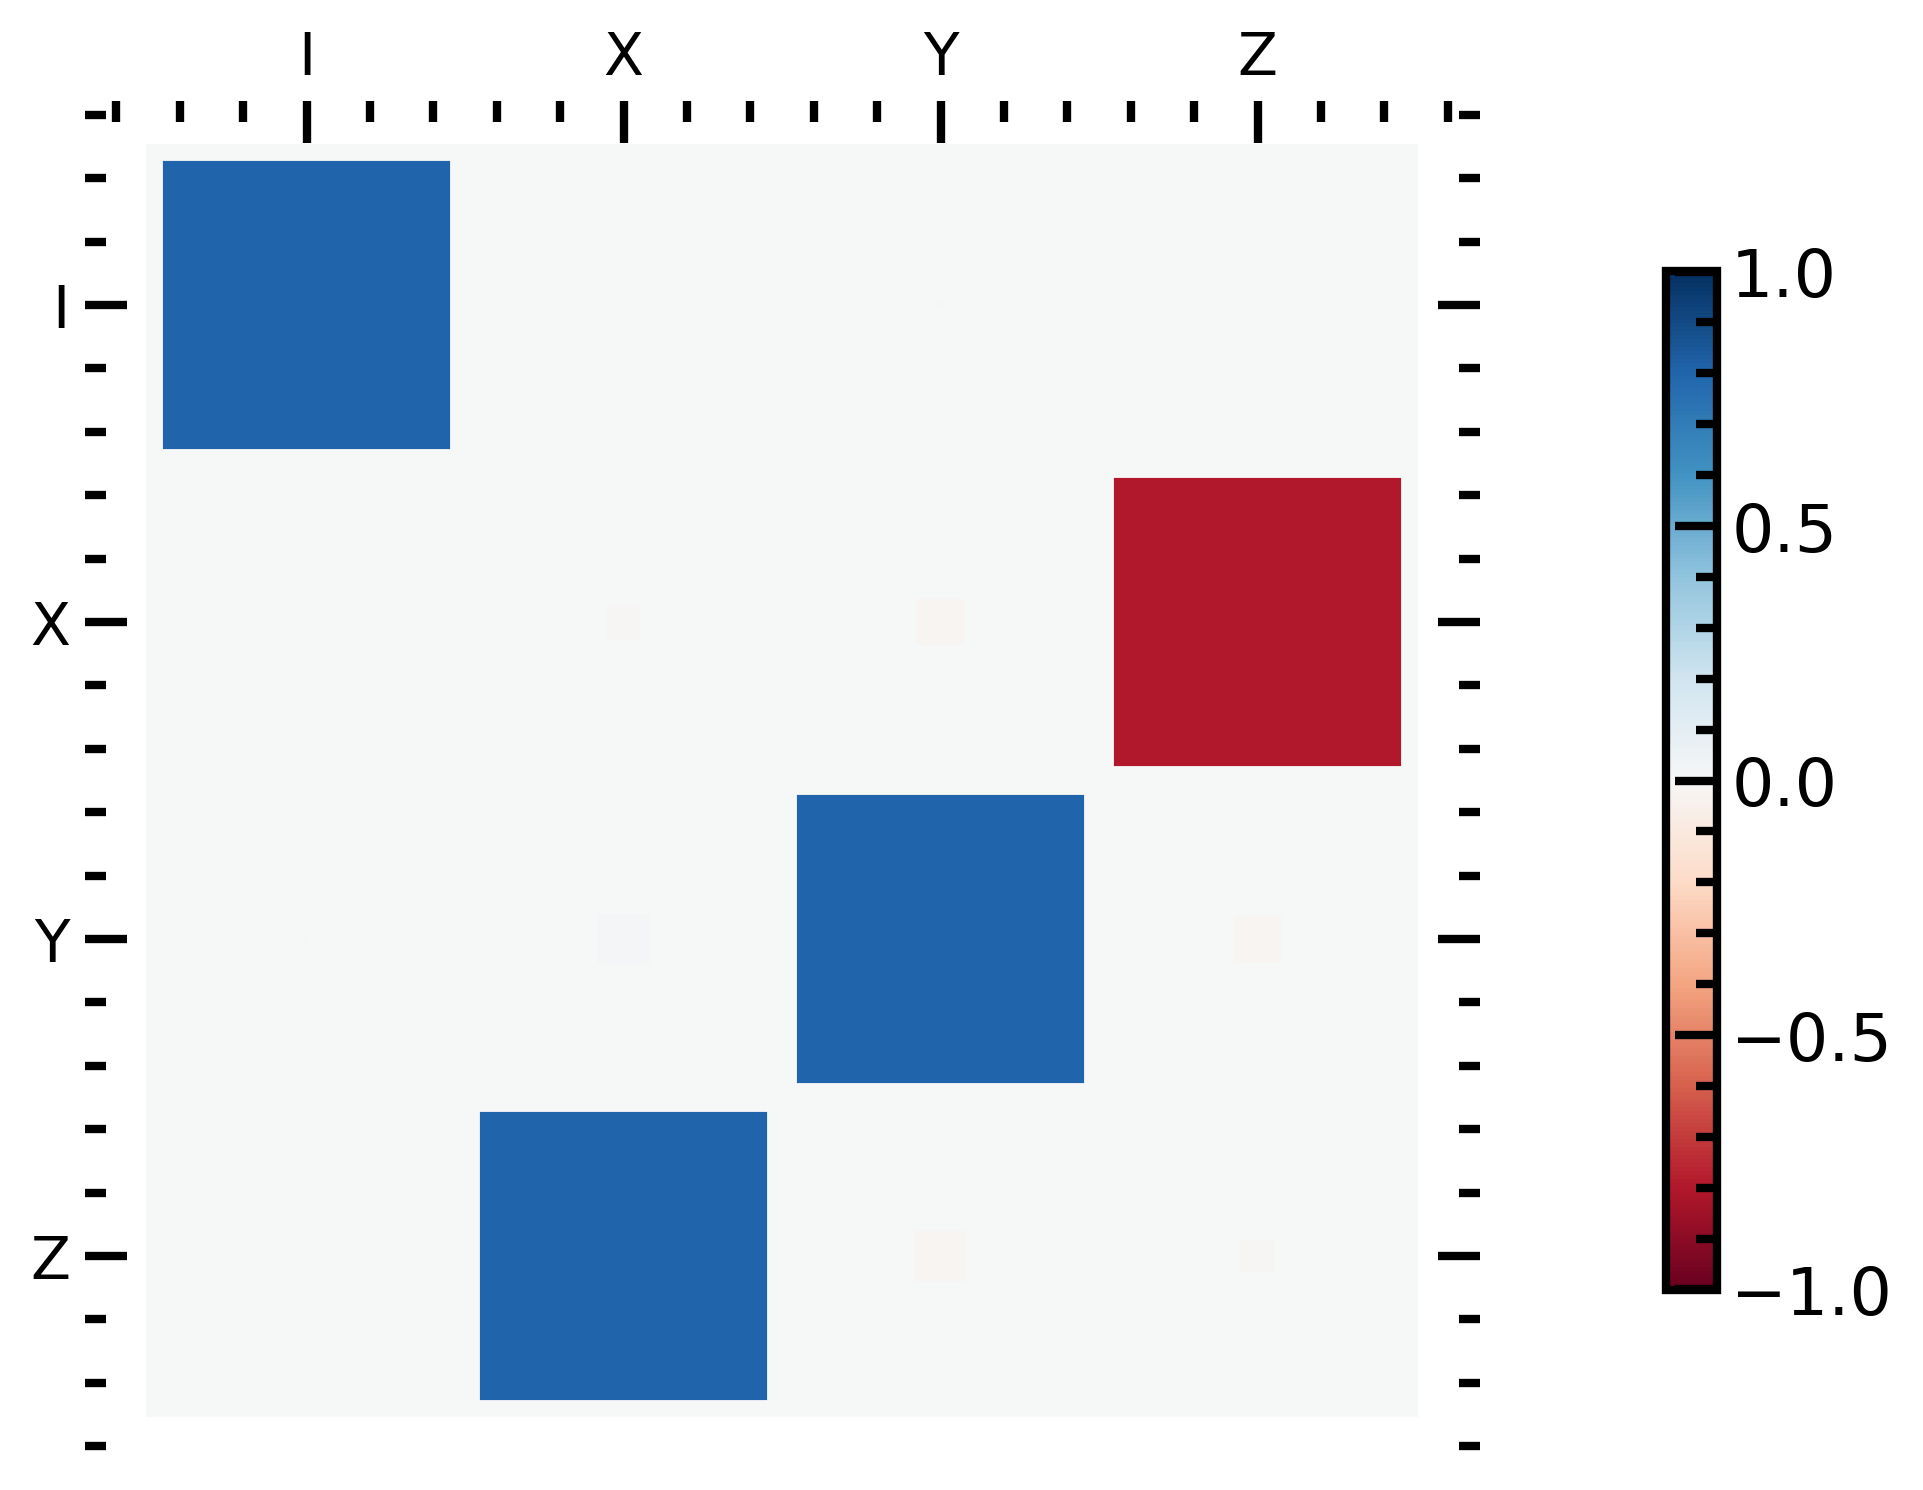

In [135]:
prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)

T_gate = T_gate_23 + T_gate_02*2
t_points = np.linspace(0, T_gate, 10*(T_gate)+3)
U_nothing_1 = gates_double.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)

U_nothing_2 = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)

for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states_1 = gates_double.evolution_psi_microwave(
                qubit.H(), H_drive_02,psi0 = psi_ini, t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    evol_states_2 = gates.evolution_psi_microwave(H_nodrive, H_drive_23, psi0 = U_nothing_1[-1]*evol_states_1[-1], t_points=t_points_23, DRAG = drag,
                                            T_gate=T_gate_23, shape=shape, omega_d=omega_d_23, DRAG_coefficient= drag_coeff_23)
    evol_states_3 = gates_double.evolution_psi_microwave(
                qubit.H(), H_drive_02 ,psi0 = U_nothing_2[-1]*evol_states_2[-1], t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, op.sx(phi=0.2, N=nlev_single)*op.sz(phi=0.2, N=nlev_single)*U_nothing_1[-1]*evol_states_3[-1]))
        
ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])       
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)       

In [136]:
d = 2
process_fidelity = ((ptm_real.dag()*ptm_ideal).tr() + d)/(d**2+d)
print (process_fidelity)

1.0006431501446922


## Estimate the error channel

In [141]:
#List of collapse operators
gamma1_01 = (50e6)**-1.0
gamma2_01 = (5e3)**-1.0
L1_01 = np.sqrt(gamma1_01)*state_0*state_1.dag()
L2_01 = np.sqrt(2*gamma2_01)*state_1*state_1.dag()

gamma1_02 = (53e3)**-1
gamma2_02 = (52e3)**-1
L1_02 = np.sqrt(gamma1_02)*state_0*state_2.dag()
L2_02 = np.sqrt(2*gamma2_02)*state_2*state_2.dag()

gamma1_13 = (58e3)**-1
gamma2_13 = (33e3)**-1
L1_13 = np.sqrt(gamma1_13)*state_1*state_3.dag()
L2_13 = np.sqrt(2*gamma2_13)*state_3*state_3.dag()

gamma1_23 = (306e3)**-1
gamma2_23 = (7e3)**-1
L1_23 = np.sqrt(gamma1_23)*state_2*state_3.dag()
L2_23 = np.sqrt(2*gamma2_23)*state_3*state_3.dag()

gamma1_12 = (786e3)**-1
gamma2_12 = (6e3)**-1
L1_12 = np.sqrt(gamma1_12)*state_1*state_2.dag()
L2_12 = np.sqrt(2*gamma2_12)*state_2*state_2.dag()

gamma1_03 = (697e3)**-1
gamma2_03 = (6e3)**-1
L1_03 = np.sqrt(gamma1_03)*state_0*state_3.dag()
L2_03 = np.sqrt(2*gamma2_03)*state_3*state_3.dag()

c_ops = [L1_01,L2_01, L1_02,L2_02, L1_13,L2_13, L1_23,L2_23, L1_12,L2_12, L1_03,L2_03]

<ipython-input-144-ef4c2f533e0a>:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8708bf2730>)

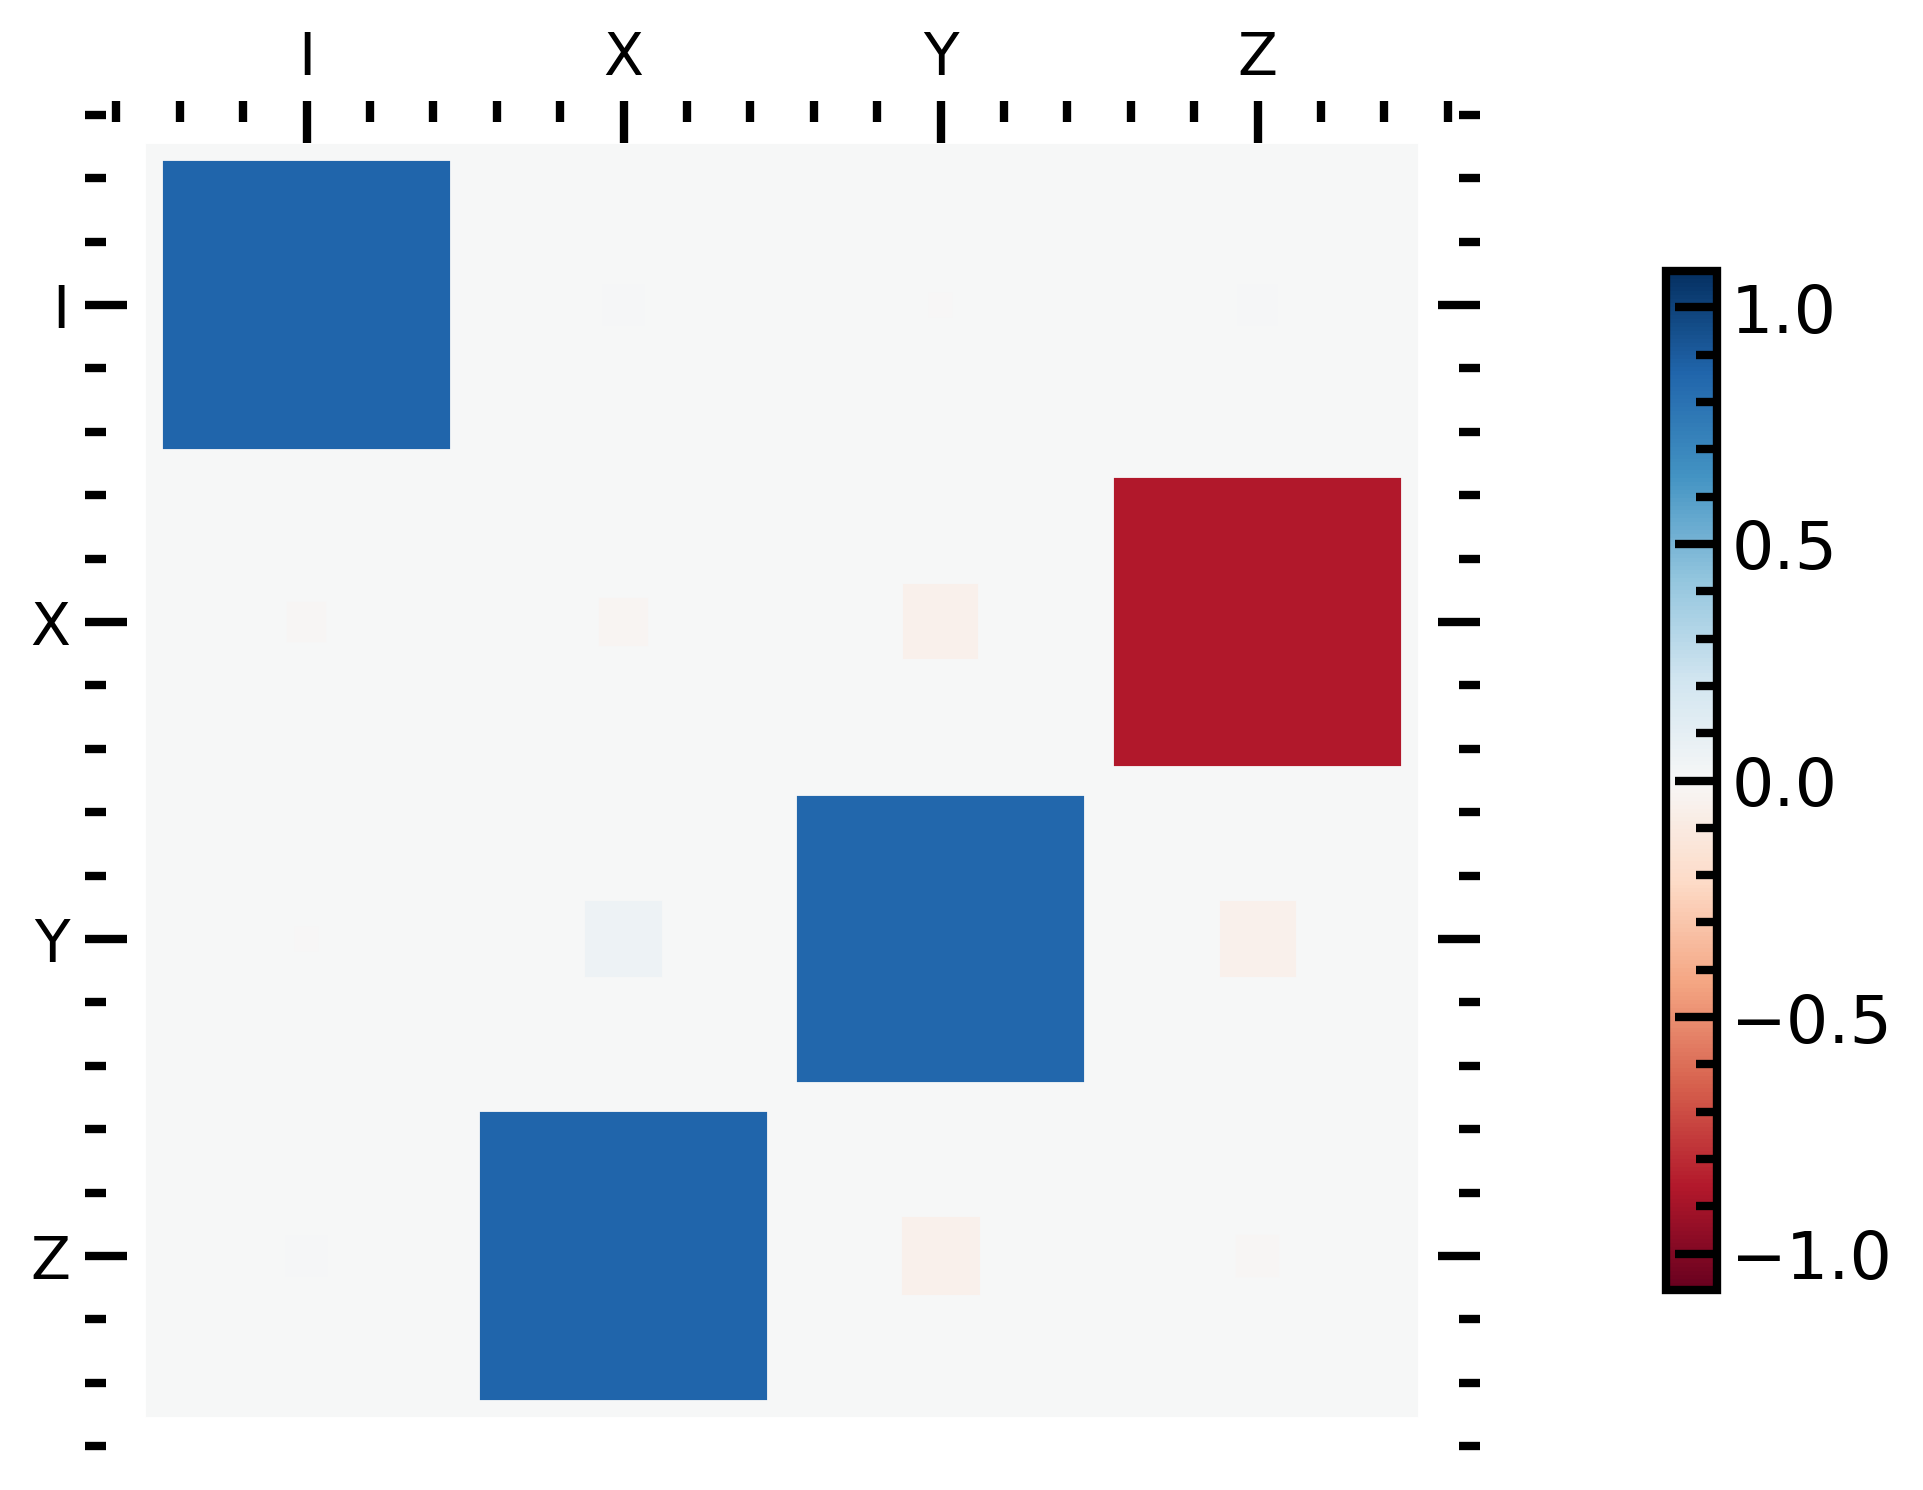

In [144]:
prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)

T_gate = T_gate_23 + T_gate_02*2
t_points = np.linspace(0, T_gate, 10*(T_gate)+3)
U_nothing_1 = gates_double.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio)

U_nothing_2 = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points_23, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate_23, shape=shape, sigma=sigma, omega_d=omega_d)

for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states_1 = gates_double.evolution_psi_microwave_diss(
                qubit.H(), H_drive_02,psi0 = psi_ini, t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio, c_ops = c_ops)
    evol_states_2 = gates.evolution_psi_microwave_diss(H_nodrive, H_drive_23, psi0 = U_nothing_1[-1]*evol_states_1[-1], t_points=t_points_23, DRAG = drag,
                                            T_gate=T_gate_23, shape=shape, omega_d=omega_d_23, DRAG_coefficient= drag_coeff_23, c_ops = c_ops)
    evol_states_3 = gates_double.evolution_psi_microwave_diss(
                qubit.H(), H_drive_02 ,psi0 = U_nothing_2[-1]*evol_states_2[-1], t_points=t_points_02, drive_ratio=drive_ratio, DRAG = drag, DRAG_coefficient = drag_coeff_02,
                T_gate=T_gate_02, shape=shape, sigma=sigma, omega_d_1=omega_d_1,omega_d_2=omega_d_2,drag_coeff_ratio = drag_coeff_ratio, c_ops = c_ops)
    psi_fin = U_nothing_1[-1]*evol_states_3[-1]*U_nothing_1[-1].dag()
    psi_fin = op.sx(phi=0.2, N=nlev_single)*op.sz(phi=0.2, N=nlev_single)*psi_fin*op.sz(phi=0.2, N=nlev_single).dag()*op.sx(phi=0.2, N=nlev_single).dag()
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, psi_fin))
        
ptm_real =  Qobj(np.linalg.lstsq(p_out, p_in)[0])       
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

In [138]:
process_fidelity = ((ptm_real.dag()*ptm_ideal).tr() + d)/(d**2+d)
print (process_fidelity)

-0.8355703200107154


(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f870ba7d070>)

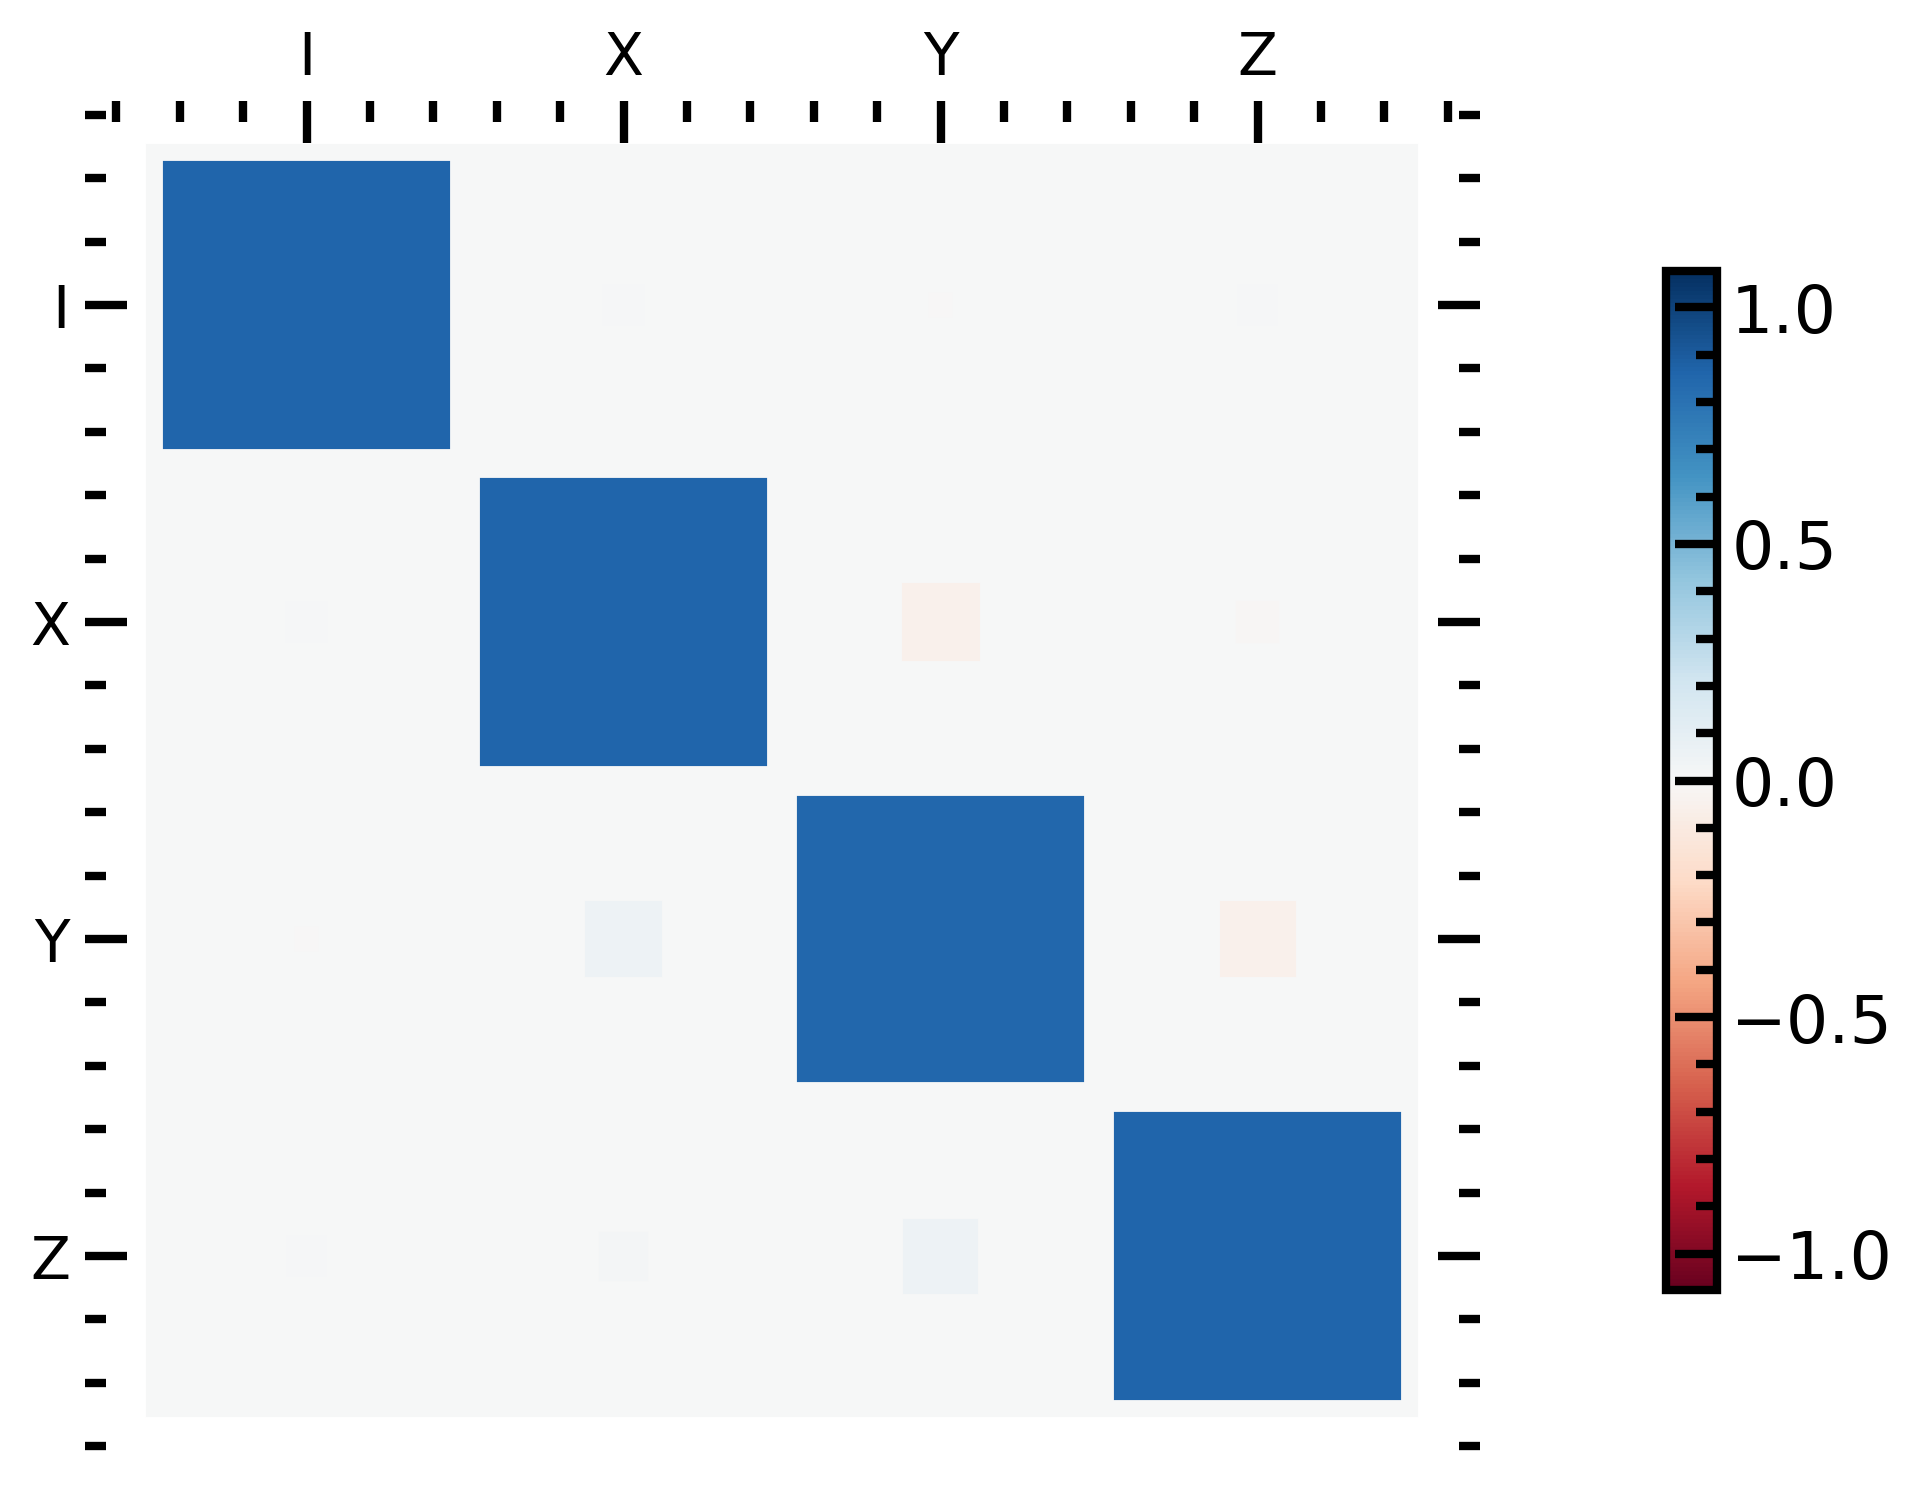

In [145]:
ptm_error = ptm_real*np.linalg.inv(ptm_ideal)
hinton(ptm_error, xlabels = op_label, ylabels = op_label) 